# Regression Task: Parts A and B

Group 121:
* Juan Manuel Rodriguez
* Vladyslav Horbatenko
* Aryan Mirzazadeh

In [1]:
# Common imports for all parts (Regression and Classification)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import scipy.stats as st

# Custom Color Palette for the Report
# Soft, appealing color scheme for consistent visualization
COLORS = {
    # Primary model colors
    'linear_regression': '#6BA3D0',      # Soft blue
    'ann': '#B892C4',                    # Soft lavender
    'knn': '#F4A261',                    # Soft coral
    'baseline': '#95A5A6',               # Soft gray
    'logistic_regression': '#6BA3D0',    # Same as linear regression (soft blue)
    
    # Semantic colors
    'positive': '#6BA3D0',               # Soft blue for positive values
    'negative': '#E88D8D',               # Soft rose for negative values
    'optimal': '#E88D8D',                # Soft rose for optimal points/markers
    'error': '#B0BEC5',                  # Light blue-gray for error bars
    
    # Accent colors
    'accent1': '#B892C4',                # Soft lavender
    'accent2': '#F4A261',                # Soft coral
    'accent3': '#81C995',                # Soft mint green
    'accent4': '#E9C899',                # Soft peach
    
    # Heatmap colormap
    'heatmap': 'RdPu',                   # Soft Red-Purple for heatmaps
}

# Data Loading and Transformation

Load the heart disease dataset and apply necessary transformations. We will drop the `obesity` column as it won't be used in our analysis.


In [2]:
# Load and transform the data
df_heart = pd.read_csv(
    "https://hastie.su.domains/ElemStatLearn/datasets/SAheart.data",
    sep=",",
    header=0,
    index_col=0,
)

columns_ordered = [
    "sbp",
    "ldl",
    "adiposity",
    "obesity",
    "typea",
    "age",
    "tobacco",
    "alcohol",
    "famhist",
    "chd",
]

missing = [c for c in columns_ordered if c not in df_heart.columns]
if missing:
    raise KeyError(f"Missing columns in df_heart: {missing}")

df_heart = df_heart[columns_ordered]

# Drop obesity column as it won't be used
df_heart = df_heart.drop(columns=["obesity"])

# Binary transformation of categorical attribute
df_heart['famhist'] = df_heart['famhist'].map({'Present': 1, 'Absent': 0})

# Log transform skewed columns
columns_to_log_transform = ['tobacco', 'alcohol']
for column in columns_to_log_transform:
    df_heart[column] = np.log1p(df_heart[column])

# Standardize the data to have mean = 0 and variance = 1
df_heart_standarized = (df_heart - df_heart.mean()) / df_heart.std()
df_heart_standarized["famhist"] = df_heart["famhist"]

df_heart_standarized.head()


,sbp,ldl,adiposity,typea,age,tobacco,alcohol,famhist,chd
row.names,,,,,,,,,
1,1.057417,0.477894,-0.295183,-0.418017,0.628654,1.576878,1.772852,1,1.372375
2,0.276789,-0.159507,0.411694,0.193134,1.381617,-1.193044,-0.563821,0,1.372375
3,-0.991731,-0.608585,0.883374,-0.112441,0.217947,-1.120397,-0.259134,1,-0.727086
4,1.545310,0.806252,1.622382,-0.214300,1.039361,1.116254,0.858159,1,1.372375
5,-0.211103,-0.598928,0.305020,0.702427,0.423301,1.702714,1.422062,1,1.372375


---

# Part A: Regularized Linear Regression

### Target Variable
- **sbp** (systolic blood pressure): A continuous variable representing the maximum arterial pressure during heart contraction. This is our regression target.

### Features
We use the following features to predict sbp:
- **ldl**: Low-density lipoprotein cholesterol
- **adiposity**: Adiposity measure
- **typea**: Type A behavior score
- **age**: Age of the patient
- **tobacco**: Cumulative tobacco consumption (log-transformed)
- **alcohol**: Current alcohol consumption (log-transformed)
- **famhist**: Family history of coronary heart disease (binary: Present=1, Absent=0)
- **chd**: Coronary heart disease (binary indicator)

### Feature Transformations

To prepare the data for regularized linear regression, we apply the following transformations:

1. **Standardization**: Each feature is standardized to have mean = 0 and standard deviation = 1. This is essential for regularization, as it ensures that the regularization penalty affects all features equally regardless of their original scale.

2. **Log transformation**: The `tobacco` and `alcohol` features are log-transformed using `log1p` (log(1+x)) to handle their skewed distributions.

3. **Binary encoding**: The categorical feature `famhist` is encoded as binary (Present=1, Absent=0).

### Goal
The goal is to predict systolic blood pressure to assess cardiovascular risk. By understanding which factors contribute most to elevated blood pressure, we can better identify patients at risk and inform preventive interventions.


## 1. Regularization Parameter Tuning

We begin by examining the most elementary model, namely **linear regression**. We use **Ridge regression** (L₂ regularized linear regression), which is a unified framework that includes both ordinary linear regression and regularized linear regression:

- **When λ = 0**: Ridge regression reduces to **ordinary least squares (OLS) linear regression** - the elementary model with no regularization. This is the basic linear regression model.
- **When λ > 0**: Ridge regression applies L₂ regularization, shrinking coefficients toward zero to reduce overfitting.

The regularization parameter λ controls the trade-off between bias and variance:
- **λ = 0 (OLS)**: Low bias, high variance (may overfit) - this is the elementary linear regression model
- **Small λ**: Low bias, high variance (may overfit)
- **Optimal λ***: Best balance between bias and variance, minimizing generalization error
- **Large λ**: High bias, low variance (may underfit)

We will use **10-fold cross-validation** (Algorithm 5) to estimate the generalization error for different values of λ. We choose a range of λ values (ideally one where the generalization error first drops and then increases) to observe the characteristic U-shaped curve. The optimal λ* is selected as the value that minimizes the estimated generalization error.


In [3]:
# Prepare data for regression
# Separate features (X) and target (y)
X = df_heart_standarized.drop(columns=["sbp"])
y = df_heart_standarized["sbp"]

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

print(f"Data shape: X={X.shape}, y={y.shape}")
print(f"Features: {df_heart_standarized.drop(columns=['sbp']).columns.tolist()}")


Data shape: X=(462, 8), y=(462,)
Features: ['ldl', 'adiposity', 'typea', 'age', 'tobacco', 'alcohol', 'famhist', 'chd']


In [4]:
# Implement Algorithm 5: K-fold cross-validation for model selection using sklearn
# Choose a range of λ values (regularization parameter)
lambda_values = np.concatenate([[0.0], np.logspace(-2, 4, 200)])

# Set up 10-fold cross-validation
k_folds = 10
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Store results for each λ (all features)
results_all = {
    'lambda': [],
    'mean_mse': [],
    'std_mse': [],
    'fold_mses': []
}


In [5]:
print(f"Testing {len(lambda_values)} lambda values with {k_folds}-fold cross-validation...")
print(f"Lambda range: [{lambda_values[0]:.6f}, {lambda_values[-1]:.6f}]\n")

# For each λ value, perform cross-validation on all features
for i, lam in enumerate(lambda_values):
    fold_mses = []
    
    # K-fold cross-validation
    for train_idx, test_idx in kf.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        model = Ridge(alpha=lam, fit_intercept=True)
        model.fit(X_train, y_train)
        
        # Predict on test set
        y_pred = model.predict(X_test)
        
        # Compute MSE for this fold
        mse = mean_squared_error(y_test, y_pred)
        fold_mses.append(mse)
    
    # Compute mean and std of MSE across folds
    mean_mse = np.mean(fold_mses)
    std_mse = np.std(fold_mses)
    
    results_all['lambda'].append(lam)
    results_all['mean_mse'].append(mean_mse)
    results_all['std_mse'].append(std_mse)
    results_all['fold_mses'].append(fold_mses)
    
    if (i + 1) % 100 == 0 or i == 0:
        print(f"λ = {lam:.6f}: Mean MSE = {mean_mse:.6f} ± {std_mse:.6f}")


Testing 201 lambda values with 10-fold cross-validation...
Lambda range: [0.000000, 10000.000000]

λ = 0.000000: Mean MSE = 0.847701 ± 0.168583
λ = 9.011018: Mean MSE = 0.846486 ± 0.167937
λ = 9329.304026: Mean MSE = 0.975070 ± 0.201170


In [6]:
# Find optimal λ for all features
optimal_idx_all = np.argmin(results_all['mean_mse'])
optimal_lambda_all = results_all['lambda'][optimal_idx_all]
optimal_mse_all = results_all['mean_mse'][optimal_idx_all]
optimal_std_all = results_all['std_mse'][optimal_idx_all]

print("OPTIMAL REGULARIZATION PARAMETERS")
print(f"\nAll Features:")
print(f"\tOptimal λ* = {optimal_lambda_all:.6f}")
print(f"\tOptimal Mean MSE = {optimal_mse_all:.6f} ± {optimal_std_all:.6f}")


OPTIMAL REGULARIZATION PARAMETERS

All Features:
	Optimal λ* = 95.477161
	Optimal Mean MSE = 0.842803 ± 0.166708


In [7]:
# Results DataFrames for easier inspection
results_df_all = pd.DataFrame({
    'lambda': results_all['lambda'],
    'mean_mse': results_all['mean_mse'],
    'std_mse': results_all['std_mse']
})

print("Results around optimal λ (All Features):")
optimal_range_all = results_df_all.iloc[max(0, optimal_idx_all-2):min(len(results_df_all), optimal_idx_all+3)]
print(optimal_range_all.to_string(index=False))


Results around optimal λ (All Features):
    lambda  mean_mse  std_mse
 83.099419  0.842838 0.166612
 89.073546  0.842809 0.166652
 95.477161  0.842803 0.166708
102.341140  0.842823 0.166779
109.698580  0.842873 0.166869


In [8]:
# Use all features results as primary (for backward compatibility)
results = results_all
optimal_lambda = optimal_lambda_all
optimal_mse = optimal_mse_all
optimal_std = optimal_std_all
optimal_idx = optimal_idx_all


## 2. Visualization: Generalization Error vs Regularization Parameter

We plot the estimated generalization error (MSE) as a function of the regularization parameter λ. The optimal λ* is marked on the plot.


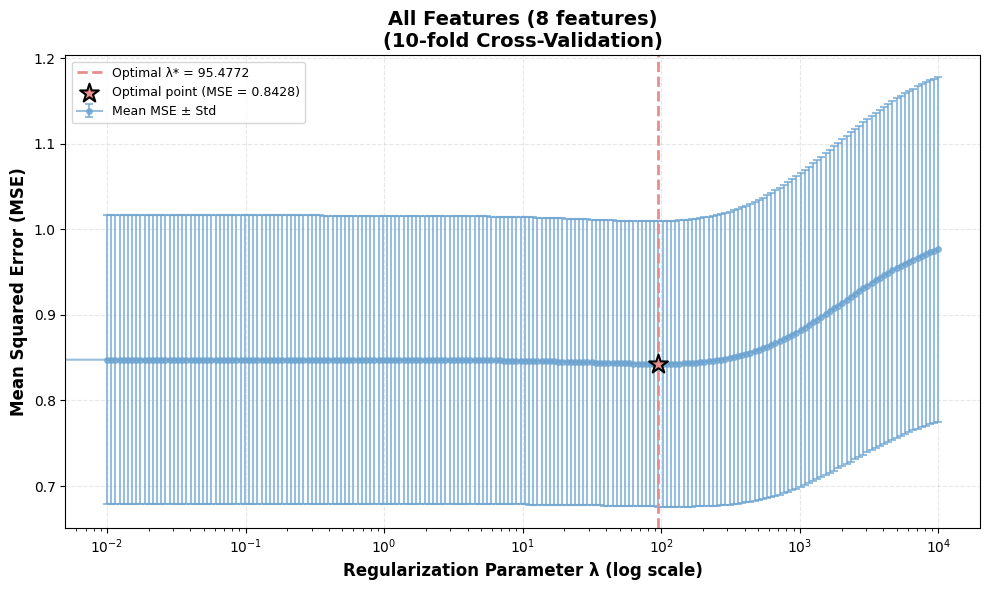

All Features - Optimal λ* = 95.477161 with MSE = 0.842803 ± 0.166708


In [9]:
# Visualization 1: MSE vs λ for All Features
fig, ax = plt.subplots(figsize=(10, 6))

ax.errorbar(results_all['lambda'], results_all['mean_mse'], 
             yerr=results_all['std_mse'], 
             fmt='o-', 
             markersize=4,
             capsize=3,
             capthick=1.5,
             elinewidth=1.5,
             label='Mean MSE ± Std',
             color=COLORS['linear_regression'],
             alpha=0.7)

# Mark optimal λ* with a vertical line
ax.axvline(x=optimal_lambda_all, 
            color=COLORS['optimal'], 
            linestyle='--', 
            linewidth=2,
            label=f'Optimal λ* = {optimal_lambda_all:.4f}')

# Mark optimal point
ax.scatter([optimal_lambda_all], [optimal_mse_all], 
           color=COLORS['optimal'], 
           s=200, 
           zorder=5,
           marker='*',
           edgecolors='black',
           linewidths=1.5,
           label=f'Optimal point (MSE = {optimal_mse_all:.4f})')

ax.set_xscale('log')
ax.set_xlabel('Regularization Parameter λ (log scale)', fontsize=12, fontweight='bold')
ax.set_ylabel('Mean Squared Error (MSE)', fontsize=12, fontweight='bold')
ax.set_title('All Features (8 features)\n(10-fold Cross-Validation)', 
              fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=9, loc='best')

plt.tight_layout()
plt.show()

print(f"All Features - Optimal λ* = {optimal_lambda_all:.6f} with MSE = {optimal_mse_all:.6f} ± {optimal_std_all:.6f}")


## 3. Train Final Model with Optimal λ*

Now we train the final Ridge regression model using the optimal regularization parameter λ* on all available data. This model will be used for interpretation and prediction.


In [10]:
# Training final model on all data with optimal λ*
print(f'Training the final model on all data with optimal λ* = {optimal_lambda_all:.6f}')
final_model_all = Ridge(alpha=optimal_lambda_all, fit_intercept=True)
final_model_all.fit(X, y)


Training the final model on all data with optimal λ* = 95.477161


,alpha,np.float64(95.47716114208056)
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [11]:
# Extract coefficients and intercept
coefficients_all = final_model_all.coef_.flatten()
intercept_all = final_model_all.intercept_

# Feature names
feature_names = df_heart_standarized.drop(columns=['sbp']).columns.tolist()

# Coefficient DataFrame for all features
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients_all
})

coef_df


,Feature,Coefficient
0,ldl,0.007386
1,adiposity,0.164100
2,typea,-0.030938
3,age,0.202970
4,tobacco,0.005327
5,alcohol,0.093075
6,famhist,-0.018018
7,chd,0.058551


In [12]:
# Sort by absolute coefficient value (importance)
coef_df['Abs_Coefficient'] = np.abs(coef_df['Coefficient'])
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

print("FINAL MODEL SUMMARY - ALL FEATURES")
print(f"Intercept (w₀): {intercept_all:.6f}")
print(f"Regularization parameter λ*: {optimal_lambda_all:.6f}")
print(f"Optimal Mean MSE (from CV): {optimal_mse_all:.6f} ± {optimal_std_all:.6f}")
print("\nCoefficients (sorted by absolute value):")
print(coef_df.to_string(index=False))

print(f"\nModel trained successfully on all {len(y)} samples.")


FINAL MODEL SUMMARY - ALL FEATURES
Intercept (w₀): 0.007488
Regularization parameter λ*: 95.477161
Optimal Mean MSE (from CV): 0.842803 ± 0.166708

Coefficients (sorted by absolute value):
  Feature  Coefficient  Abs_Coefficient
      age     0.202970         0.202970
adiposity     0.164100         0.164100
  alcohol     0.093075         0.093075
      chd     0.058551         0.058551
    typea    -0.030938         0.030938
  famhist    -0.018018         0.018018
      ldl     0.007386         0.007386
  tobacco     0.005327         0.005327

Model trained successfully on all 462 samples.


## 4. Model Interpretation

### How the Output $y$ is Computed for a Given Input $\mathbf{x}$

The linear regression model with optimal regularization parameter λ* computes the output $y$ (systolic blood pressure) for a given input $\mathbf{x}$ using the following formula:

$$y = w_0 + \sum_{i=1}^{M} w_i \cdot \hat{x}_i$$

where:
- $w_0$ is the intercept (bias term), which represents the predicted SBP when all features are at their mean values (since features are standardized)
- $w_i$ are the coefficients (weights) for each feature $i$
- $\hat{x}_i$ are the **standardized** features (mean=0, std=1) - the original features transformed to have zero mean and unit variance
- $M$ is the number of features (8 in our case)

This is the standard linear regression prediction formula. When λ = 0, this corresponds to ordinary least squares (OLS) regression. When λ > 0 (as in our optimal model with λ*), this is Ridge regression, where the coefficients $w_i$ have been regularized (shrunk toward zero) to reduce overfitting.

**Example prediction:** For a patient with standardized feature values $\hat{\mathbf{x}} = [\hat{x}_1, \hat{x}_2, \ldots, \hat{x}_8]$, the predicted SBP is:
$$y = w_0 + w_1 \hat{x}_1 + w_2 \hat{x}_2 + \cdots + w_8 \hat{x}_8$$

### Effect of Individual Attributes on the Output $y$

Since the features are standardized, the coefficients $w_i$ represent the effect of a **one standard deviation increase** in feature $i$ on the systolic blood pressure (in standardized units). This interpretation is valid because:

1. **Standardization ensures comparability**: All features are on the same scale (mean=0, std=1), so coefficients can be directly compared
2. **Linear relationship**: The effect is linear and additive - each feature contributes independently to the prediction
3. **Coefficient interpretation**:
   - **Sign**: 
     - Positive $w_i$: An increase in feature $i$ increases SBP
     - Negative $w_i$: An increase in feature $i$ decreases SBP
   - **Magnitude**: Larger absolute values $|w_i|$ indicate stronger effects on SBP

The regularization (λ* > 0) helps ensure that the coefficients are not overly large due to overfitting, making the model more stable and generalizable.


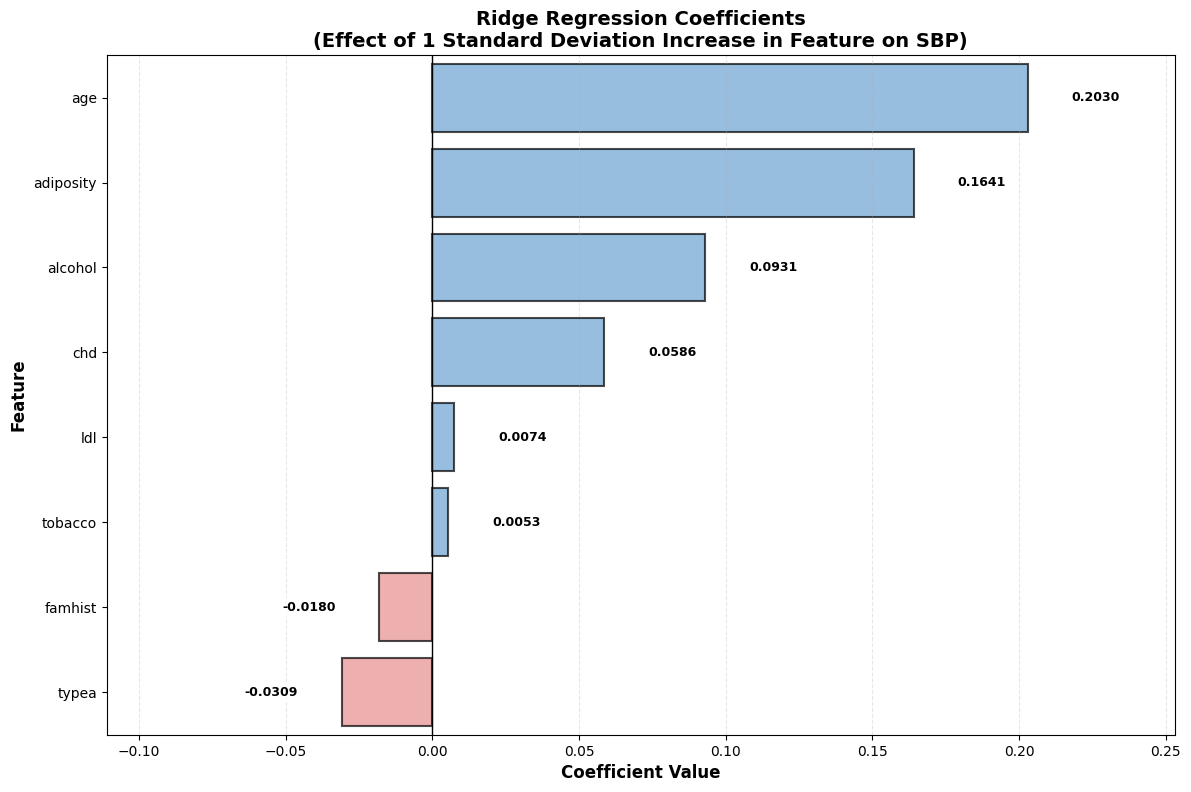

In [13]:
fig, ax = plt.subplots(figsize=(12, 8))

# Sorting
coef_df_sorted = coef_df.sort_values('Coefficient', ascending=True)

colors = [COLORS['negative'] if x < 0 else COLORS['positive'] for x in coef_df_sorted['Coefficient']]
bars = ax.barh(coef_df_sorted['Feature'], coef_df_sorted['Coefficient'], color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Vertical line at zero
ax.axvline(x=0, color='black', linestyle='-', linewidth=1)

x_min = coef_df_sorted['Coefficient'].min()
x_max = coef_df_sorted['Coefficient'].max()
ax.set_xlim(left=x_min - 0.08, right=x_max + 0.05)

# Adjust y-axis to add padding
ax.set_ylim(-0.5, len(coef_df_sorted) - 0.5)

ax.set_xlabel('Coefficient Value', fontsize=12, fontweight='bold')
ax.set_ylabel('Feature', fontsize=12, fontweight='bold')
ax.set_title('Ridge Regression Coefficients\n(Effect of 1 Standard Deviation Increase in Feature on SBP)', 
             fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x', linestyle='--')

# Position coefficient value labels with better spacing and background
for i, (idx, row) in enumerate(coef_df_sorted.iterrows()):
    value = row['Coefficient']
    # For negative values, place text further left; for positive, place further right
    offset = 0.015 if value >= 0 else -0.015
    ax.text(value + offset, i, 
            f'{value:.4f}', 
            va='center', 
            ha='left' if value >= 0 else 'right',
            fontsize=9,
            fontweight='bold',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8, edgecolor='none'))

plt.tight_layout(pad=1.0)
plt.show()


In [14]:
# Print detailed interpretation
print("\n" + "="*80)
print("COEFFICIENT INTERPRETATION")
print("="*80)
print("\nPositive coefficients (increase SBP):")
positive_coefs = coef_df[coef_df['Coefficient'] > 0].sort_values('Coefficient', ascending=False)
for _, row in positive_coefs.iterrows():
    print(f"  {row['Feature']:15s}: {row['Coefficient']:8.4f} (1 std increase → +{row['Coefficient']:.4f} std in SBP)")

print("\nNegative coefficients (decrease SBP):")
negative_coefs = coef_df[coef_df['Coefficient'] < 0].sort_values('Coefficient', ascending=True)
for _, row in negative_coefs.iterrows():
    print(f"  {row['Feature']:15s}: {row['Coefficient']:8.4f} (1 std increase → {row['Coefficient']:.4f} std in SBP)")

print("\n" + "="*80)



COEFFICIENT INTERPRETATION

Positive coefficients (increase SBP):
  age            :   0.2030 (1 std increase → +0.2030 std in SBP)
  adiposity      :   0.1641 (1 std increase → +0.1641 std in SBP)
  alcohol        :   0.0931 (1 std increase → +0.0931 std in SBP)
  chd            :   0.0586 (1 std increase → +0.0586 std in SBP)
  ldl            :   0.0074 (1 std increase → +0.0074 std in SBP)
  tobacco        :   0.0053 (1 std increase → +0.0053 std in SBP)

Negative coefficients (decrease SBP):
  typea          :  -0.0309 (1 std increase → -0.0309 std in SBP)
  famhist        :  -0.0180 (1 std increase → -0.0180 std in SBP)



---

# Part B: Two-Level Cross-Validation

In this section, we will compare three models:  
- the **regularized linear regression model** from the previous section,  
- an **artificial neural network (ANN)**, and  
- a **baseline** model.  

We are interested in two main questions:  
1. Is one model better than the other?  
2. Is either model better than a trivial baseline?  

We will attempt to answer these questions using **two-level cross-validation**.

## 1. Two-Level Cross-Validation

Implement **two-level cross-validation** (see *Algorithm 6* of the lecture notes).  
We will use **K₁ = K₂ = 10 folds** to compare the models.

### Baseline Model
As a baseline, we will apply a **linear regression model with no features**, i.e. it computes the **mean of _y_** on the training data and uses this value to predict _y_ on the test data.

### ANN Model
Make sure you can fit an **ANN model** to the data.  
As a complexity-controlling parameter for the ANN, we will use the **number of hidden units (h)**.

Based on a few test runs:
- Select a **reasonable range of values** for _h_ (which should include _h = 1_).  
- Describe the range of values you will use for both **_h_** and **_λ_**.

### Difference between Classification and Regression Models

What is the difference between a classification and regression model? The activation function used by the classification model was a Sigmoid which returns a value from 0 to 1 which allow us to classify values depending on the distance to each class, class 0 and class 1. 

In the regression model, we do not need one non-linear function after the output. This is because the Linear transformation applied after the hidden layer to transform the values into the output dimension is enough for getting the continuous value in a larger vector space. 

Why do we use ReLU for regression? ReLU is an effective and simple activation function.


In [15]:
# ANN Model Functions
# Define model initializer
def get_model(input_dim, hidden_dim, output_dim):
    return torch.nn.Sequential(
        torch.nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=True),
        torch.nn.ReLU(),
        torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True),
    )

# Train the model using MSE loss and Adam optimizer
def train_pytorch_model(model, X_train, y_train, epochs=1000, lr=0.01):
    # Convert to tensors
    X_tensor = torch.FloatTensor(X_train)
    y_tensor = torch.FloatTensor(y_train).reshape(-1, 1)
    
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_tensor)
        loss = criterion(outputs, y_tensor)
        loss.backward()
        optimizer.step()
    
    return model

# Make predictions using the model
def predict_pytorch_model(model, X_test):
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X_test)
        predictions = model(X_tensor).numpy().flatten()
    return predictions

# Ridge Regression Model Functions (using Part A)
def train_ridge_sklearn(X_train, y_train, lambda_reg):
    model = Ridge(alpha=lambda_reg, fit_intercept=True)
    model.fit(X_train, y_train)
    return model

def predict_ridge_sklearn(model, X_test):
    """Make predictions using trained sklearn Ridge model."""
    return model.predict(X_test)


To select a reasonable range of hidden units to test in the two-layer cross validation we first make a few runs using simple cross validation with 10 folds to estimate the generalization error of each number of hidden units.


In [16]:
# Test the ANN model using 10 folds with different hidden units for all data
hidden_units_list = np.arange(1, 11)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
results = {}

# Convert to numpy arrays (X and y already defined from Part A)
for hidden_units in hidden_units_list:
    fold_mse = []
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Standardize data manually
        mean_train = X_train.mean(axis=0)
        std_train = X_train.std(axis=0)
        X_train = (X_train - mean_train) / std_train
        X_test = (X_test - mean_train) / std_train
        
        model = get_model(input_dim=X.shape[1], hidden_dim=hidden_units, output_dim=1)
        model = train_pytorch_model(model, X_train, y_train, epochs=1000, lr=0.01)
        y_pred = predict_pytorch_model(model, X_test)
        
        mse = mean_squared_error(y_test, y_pred)
        fold_mse.append(mse)
    
    results[hidden_units] = np.mean(fold_mse)

results_df_hidden_units = pd.DataFrame(list(results.items()), columns=["Hidden Units", "Mean MSE"])
print(results_df_hidden_units)


   Hidden Units  Mean MSE
0             1  0.875778
1             2  0.863340
2             3  0.989772
3             4  0.920435
4             5  1.059914
5             6  1.062359
6             7  1.051484
7             8  1.057379
8             9  1.079680
9            10  1.117852


We observe that as the number of hidden units increases, the mean squared error tends to rise when tested on both the general data and the PCA-transformed data. The optimal number of hidden units appears to range between 1 and 5, showing the lowest generalization error in the simple 10-fold cross-validation.

Additionally, we notice a slightly lower MSE when using the PCA-transformed data.


## Explanation: Nested Cross-Validation Function

This function implements **two-level (nested) cross-validation** to compare three models:
1. **Baseline**: Predicts the mean of y (no features)
2. **Ridge Regression**: Regularized linear regression with optimal λ* selected via inner CV
3. **ANN**: Neural network with optimal h* (hidden units) selected via inner CV

### How Results from Part A are Used:

- **Lambda range**: From Part A, we found that λ values in the range `np.concatenate([[0.0], np.logspace(-4, 4, 200)])` (0.0 to 10,000) work well. This range is used as the default `lambda_range` parameter.
- **Ridge Regression code**: We use sklearn's `Ridge` model (same as Part A) with `train_ridge_sklearn`/`predict_ridge_sklearn` functions.

### Step-by-Step Process:

#### **Level 1: Outer Cross-Validation (10 folds)**
For each of the 10 outer folds:
1. **Split data**: Divide into outer training set (90%) and outer test set (10%)
2. **Standardize**: Standardize features using mean/std from outer training set only
3. **Evaluate three models** (all use the same train/test split for fair comparison):

#### **Level 2: Inner Cross-Validation (10 folds) - For Hyperparameter Selection**

**For Ridge Regression (λ selection):**
- For each λ in the range (200 values from Part A):
  - Perform 10-fold inner CV on the outer training set
  - For each inner fold: train Ridge model, evaluate on inner validation set
  - Compute average MSE across inner folds
- **Select optimal λ***: The λ with lowest average inner CV error
- **Train final model**: Train Ridge regression on entire outer training set with optimal λ*
- **Evaluate**: Test on outer test set → get `linreg_test_error`

**For ANN (h selection):**
- For each h in `hidden_units_range` (e.g., [1, 2, 3, 4, 5]):
  - Perform 10-fold inner CV on the outer training set
  - For each inner fold: train ANN, evaluate on inner validation set
  - Compute average MSE across inner folds
- **Select optimal h***: The h with lowest average inner CV error
- **Train final model**: Train ANN on entire outer training set with optimal h*
- **Evaluate**: Test on outer test set → get `ann_test_error`

**For Baseline:**
- Simply compute mean of y from outer training set
- **Evaluate**: Test on outer test set → get `baseline_test_error`

### Results We Get:

1. **`results_df`**: DataFrame with one row per outer fold containing:
   - `outer_fold`: Fold number (1-10)
   - `h_star`: Optimal hidden units for that fold
   - `lambda_star`: Optimal λ for that fold
   - `ann_test_error`: ANN test error on that fold
   - `linreg_test_error`: Ridge regression test error on that fold
   - `baseline_test_error`: Baseline test error on that fold

2. **`summary_table`**: Formatted table matching the assignment format (Table 1)

3. **`inner_errors_df`**: DataFrame with inner CV errors for ANN (for visualization/analysis)

4. **`best_model`**: String indicating which model performed best overall (lowest mean test error)

### Key Points:

- **Same splits for all models**: All three models use identical outer train/test splits, allowing fair statistical comparison
- **Hyperparameter selection**: λ* and h* are selected independently for each outer fold via inner CV
- **Unbiased evaluation**: Outer test set is never used for hyperparameter selection, giving unbiased performance estimates


In [17]:
def nested_cross_validation(X, y, hidden_units_range=[1, 2, 3, 4, 5],
                           lambda_range=None,
                           outer_folds=10, inner_folds=10, random_state=42,
                           epochs=1000, lr=0.01):
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)

    if lambda_range is None:
        lambda_range = np.concatenate([[0.0], np.logspace(-4, 4, 200)])

    # Outer cross-validation
    outer_cv = KFold(n_splits=outer_folds, shuffle=True, random_state=random_state)

    # Store results for each outer fold
    outer_fold_results = []
    all_inner_errors = []
    all_inner_errors_lambda = []
    
    # Outer fold loop
    for outer_idx, (train_outer_idx, test_outer_idx) in enumerate(outer_cv.split(X), 1):
        print(f"\nProcessing Outer Fold {outer_idx}/{outer_folds}")
        print("-" * 50)

        X_train_outer, X_test_outer = X[train_outer_idx], X[test_outer_idx]
        y_train_outer, y_test_outer = y[train_outer_idx], y[test_outer_idx]

        # Standardize the data manually for each outer fold
        # Compute mean and std from training data only
        mean_outer = X_train_outer.mean(axis=0)
        std_outer = X_train_outer.std(axis=0)

        # Apply the same transformation to both training and test sets
        X_train_outer_scaled = (X_train_outer - mean_outer) / std_outer
        X_test_outer_scaled = (X_test_outer - mean_outer) / std_outer

        # BASELINE MODEL: Predict mean
        baseline_prediction = np.mean(y_train_outer)
        baseline_test_error = mean_squared_error(y_test_outer, 
                                                  np.full(len(y_test_outer), baseline_prediction))
        print(f"Baseline test error: {baseline_test_error:.6f}")

        # INNER CROSS-VALIDATION: Create splits once, then test both hyperparameters
        print(f"\n  Setting up Inner CV with {inner_folds} folds...")
        inner_cv = KFold(n_splits=inner_folds, shuffle=True, random_state=random_state)
        
        # Pre-compute all inner splits (store as list of tuples)
        inner_splits = list(inner_cv.split(X_train_outer_scaled))
        print(f"  Created {len(inner_splits)} inner train/validation splits")
        
        # HYPERPARAMETER SELECTION: Test λ range (Ridge Regression)
        print(f"\n  Testing {len(lambda_range)} λ values for Ridge Regression...")
        best_lambda = None
        best_inner_error_lambda = float('inf')
        lambda_results = []

        for lam in lambda_range:
            inner_fold_errors_lambda = []
            
            # Use pre-computed inner splits
            for inner_fold_idx, (train_inner_idx, val_inner_idx) in enumerate(inner_splits, 1):
                X_train_inner = X_train_outer_scaled[train_inner_idx]
                X_val_inner = X_train_outer_scaled[val_inner_idx]
                y_train_inner = y_train_outer[train_inner_idx]
                y_val_inner = y_train_outer[val_inner_idx]

                # Train Ridge regression model using sklearn (same as Part A)
                ridge_model = train_ridge_sklearn(X_train_inner, y_train_inner, lambda_reg=lam)

                # Predict on validation set
                y_pred_inner = predict_ridge_sklearn(ridge_model, X_val_inner)
                mse = mean_squared_error(y_val_inner, y_pred_inner)
                inner_fold_errors_lambda.append(mse)

            # Average error across inner folds
            avg_inner_error_lambda = np.mean(inner_fold_errors_lambda)
            std_inner_error_lambda = np.std(inner_fold_errors_lambda)

            # Store for plotting
            all_inner_errors_lambda.append({
                'outer_fold': outer_idx,
                'lambda': lam,
                'avg_mse': avg_inner_error_lambda
            })
            
            lambda_results.append({
                'lambda': lam,
                'avg_mse': avg_inner_error_lambda,
                'std_mse': std_inner_error_lambda
            })

            # Track best lambda
            if avg_inner_error_lambda < best_inner_error_lambda:
                best_inner_error_lambda = avg_inner_error_lambda
                best_lambda = lam

        # Print summary of λ selection
        print(f"  Best λ* = {best_lambda:.6f} (avg inner CV MSE: {best_inner_error_lambda:.6f})")

        # Final Ridge regression model on entire outer training set
        final_ridge_model = train_ridge_sklearn(X_train_outer_scaled, y_train_outer, lambda_reg=best_lambda)
        y_pred_linreg = predict_ridge_sklearn(final_ridge_model, X_test_outer_scaled)
        linreg_test_error = mean_squared_error(y_test_outer, y_pred_linreg)
        print(f"  Linear Regression test error: {linreg_test_error:.6f}")

        # ========================================================================
        # HYPERPARAMETER SELECTION: Test h range (ANN)
        # ========================================================================
        print(f"\n  Testing {len(hidden_units_range)} hidden unit values for ANN...")
        best_hidden_units = None
        best_inner_error = float('inf')
        h_results = []

        for h in hidden_units_range:
            inner_fold_errors = []

            # Use pre-computed inner splits (same splits as for λ)
            for inner_fold_idx, (train_inner_idx, val_inner_idx) in enumerate(inner_splits, 1):
                X_train_inner = X_train_outer_scaled[train_inner_idx]
                X_val_inner = X_train_outer_scaled[val_inner_idx]
                y_train_inner = y_train_outer[train_inner_idx]
                y_val_inner = y_train_outer[val_inner_idx]

                # Standardize the data for each inner fold (for ANN)
                mean_inner = X_train_inner.mean(axis=0)
                std_inner = X_train_inner.std(axis=0)

                # Apply same scaling to both sets
                X_train_inner_scaled = (X_train_inner - mean_inner) / std_inner
                X_val_inner_scaled = (X_val_inner - mean_inner) / std_inner

                # Train neural network
                model = get_model(input_dim=X_train_inner.shape[1], 
                                hidden_dim=h, 
                                output_dim=1)
                model = train_pytorch_model(model, X_train_inner_scaled, y_train_inner, 
                                          epochs=epochs, lr=lr)

                # Predict on validation set
                y_pred_inner = predict_pytorch_model(model, X_val_inner_scaled)
                mse = mean_squared_error(y_val_inner, y_pred_inner)
                inner_fold_errors.append(mse)

            # Average error across inner folds
            avg_inner_error = np.mean(inner_fold_errors)
            std_inner_error = np.std(inner_fold_errors)

            # Store for plotting
            all_inner_errors.append({
                'outer_fold': outer_idx,
                'hidden_units': h,
                'avg_mse': avg_inner_error
            })
            
            h_results.append({
                'hidden_units': h,
                'avg_mse': avg_inner_error,
                'std_mse': std_inner_error
            })

            # Track best hidden units
            if avg_inner_error < best_inner_error:
                best_inner_error = avg_inner_error
                best_hidden_units = h

        # Print summary of h selection
        print(f"  Best h* = {best_hidden_units} (avg inner CV MSE: {best_inner_error:.6f})")
        print(f"  h selection results:")
        for res in h_results:
            marker = " <-- BEST" if res['hidden_units'] == best_hidden_units else ""
            print(f"    h={res['hidden_units']}: MSE={res['avg_mse']:.6f} ± {res['std_mse']:.6f}{marker}")

        # Train final neural network on entire outer training set
        final_model = get_model(input_dim=X_train_outer_scaled.shape[1], 
                               hidden_dim=best_hidden_units, 
                               output_dim=1)
        final_model = train_pytorch_model(final_model, X_train_outer_scaled, y_train_outer,
                                         epochs=epochs, lr=lr)
        y_pred_outer = predict_pytorch_model(final_model, X_test_outer_scaled)
        ann_test_error = mean_squared_error(y_test_outer, y_pred_outer)
        print(f"  ANN test error: {ann_test_error:.6f}")

        # Store results for this outer fold
        outer_fold_results.append({
            'outer_fold': outer_idx,
            'h_star': best_hidden_units,
            'lambda_star': best_lambda,
            'ann_test_error': ann_test_error,
            'linreg_test_error': linreg_test_error,
            'baseline_test_error': baseline_test_error
        })

    # Create results dataframe
    results_df = pd.DataFrame(outer_fold_results)
    inner_errors_df = pd.DataFrame(all_inner_errors)

    # Create summary table in the format shown
    summary_table = pd.DataFrame({
        'Outer fold': results_df['outer_fold'],
        'ANN h*': results_df['h_star'],
        'ANN E^test': results_df['ann_test_error'],
        'LinReg λ*': results_df['lambda_star'],
        'LinReg E^test': results_df['linreg_test_error'],
        'Baseline E^test': results_df['baseline_test_error']
    })

    # Print summary table
    print("\n" + "=" * 80)
    print("OUTER FOLD RESULTS TABLE")
    print(summary_table.to_string(index=False))
    
    print("\n" + "=" * 80)
    print("GENERALIZATION ERROR STATISTICS")
    print(f"ANN Mean Test Error:              {results_df['ann_test_error'].mean():.4f} ± {results_df['ann_test_error'].std():.4f}")
    print(f"Linear Regression Mean Test Error: {results_df['linreg_test_error'].mean():.4f} ± {results_df['linreg_test_error'].std():.4f}")
    print(f"Baseline Mean Test Error:          {results_df['baseline_test_error'].mean():.4f} ± {results_df['baseline_test_error'].std():.4f}")

    # Count optimal hidden units
    print("\n" + "=" * 80)
    print("OPTIMAL HIDDEN UNITS FREQUENCY")
    h_counts = results_df['h_star'].value_counts().sort_index()
    for h, count in h_counts.items():
        print(f"h* = {h}: selected in {count}/{outer_folds} folds")
    
    # Count optimal lambda values
    print("\n" + "=" * 80)
    print("OPTIMAL REGULARIZATION PARAMETER STATISTICS")
    print(f"Mean λ*: {results_df['lambda_star'].mean():.6f}")
    print(f"Std λ*: {results_df['lambda_star'].std():.6f}")
    print(f"Min λ*: {results_df['lambda_star'].min():.6f}")
    print(f"Max λ*: {results_df['lambda_star'].max():.6f}")
    
    # Determine best overall model
    print("\n" + "=" * 80)
    print("BEST OVERALL MODEL")
    mean_errors = {
        'ANN': results_df['ann_test_error'].mean(),
        'Linear Regression': results_df['linreg_test_error'].mean(),
        'Baseline': results_df['baseline_test_error'].mean()
    }
    
    best_model = min(mean_errors, key=mean_errors.get)
    best_error = mean_errors[best_model]
    
    print(f"Best Model: {best_model}")
    print(f"Mean Test Error: {best_error:.4f}")
    print(f"\nRanking:")
    for rank, (model, error) in enumerate(sorted(mean_errors.items(), key=lambda x: x[1]), 1):
        print(f"  {rank}. {model}: {error:.4f}")
    
    if best_model == 'ANN':
        # Most frequent optimal h*
        most_common_h = results_df['h_star'].mode()[0]
        h_frequency = (results_df['h_star'] == most_common_h).sum()
        print(f"\nMost common optimal hidden units: h* = {most_common_h} ({h_frequency}/{outer_folds} folds)")

    return results_df, summary_table, inner_errors_df, best_model


In [18]:
# Run nested cross-validation for all data
# This will take some time as it performs nested CV with inner loops for both λ and h selection

print("NESTED CROSS-VALIDATION: ALL DATA")
results_df, summary_table, inner_errors_df, best_model = nested_cross_validation(
    X, y,
    outer_folds=10,
    inner_folds=10,
    random_state=42,
    epochs=1000,
    lr=0.01
)

print(f"\nThe best model is: {best_model}")


NESTED CROSS-VALIDATION: ALL DATA

Processing Outer Fold 1/10
--------------------------------------------------
Baseline test error: 1.011163

  Setting up Inner CV with 10 folds...
  Created 10 inner train/validation splits

  Testing 201 λ values for Ridge Regression...
  Best λ* = 128.989026 (avg inner CV MSE: 0.861944)
  Linear Regression test error: 0.755813

  Testing 5 hidden unit values for ANN...
  Best h* = 1 (avg inner CV MSE: 0.897338)
  h selection results:
    h=1: MSE=0.897338 ± 0.241474 <-- BEST
    h=2: MSE=0.921044 ± 0.182824
    h=3: MSE=0.962722 ± 0.217335
    h=4: MSE=1.029233 ± 0.247510
    h=5: MSE=1.060095 ± 0.180128
  ANN test error: 0.735399

Processing Outer Fold 2/10
--------------------------------------------------
Baseline test error: 1.184250

  Setting up Inner CV with 10 folds...
  Created 10 inner train/validation splits

  Testing 201 λ values for Ridge Regression...
  Best λ* = 117.584955 (avg inner CV MSE: 0.832511)
  Linear Regression test error:

In [19]:
# Compare Linear Regression with all data
# Print mean errors for each linear model from summary tables
mean_linreg_error_all = summary_table['LinReg E^test'].mean()
print(f"\nMean Linear Regression Test Error (All Data): {mean_linreg_error_all:.4f}")

# Print mean errors for each ANN model from summary tables
mean_ann_error_all = summary_table['ANN E^test'].mean()
print(f"\nMean ANN Test Error (All Data): {mean_ann_error_all:.4f}")



Mean Linear Regression Test Error (All Data): 0.8435

Mean ANN Test Error (All Data): 0.8605


### Model Performance Comparison

Based on the two-level cross-validation results, **Linear Regression** achieved a slightly better mean test error compared to the ANN. This indicates that Linear Regression is the better-performing model for predicting systolic blood pressure (SBP) on this dataset.

**Why did Linear Regression perform better?**

The results strongly suggest that the relationship between the features and SBP is predominantly linear. This is evidenced by several key observations:

1. **Optimal hidden units selection**: The best number of hidden units (h*) was selected as 1 in most outer folds. This pattern indicates that adding non-linearity (more hidden units) consistently worsens model performance.

2. **Minimal difference between models**: When h* = 1, the ANN with a single ReLU activation function produces nearly identical predictions to linear regression. The only difference is the presence of a single ReLU activation, which in practice has minimal effect when the optimal architecture is essentially linear.

3. **Increasing complexity degrades performance**: As the number of hidden units increases from 1 to 5, the inner CV MSE consistently increases across all folds, demonstrating that additional non-linearity adds unnecessary complexity without improving predictive power.

Both the ANN and Linear Regression models clearly outperform the baseline model.


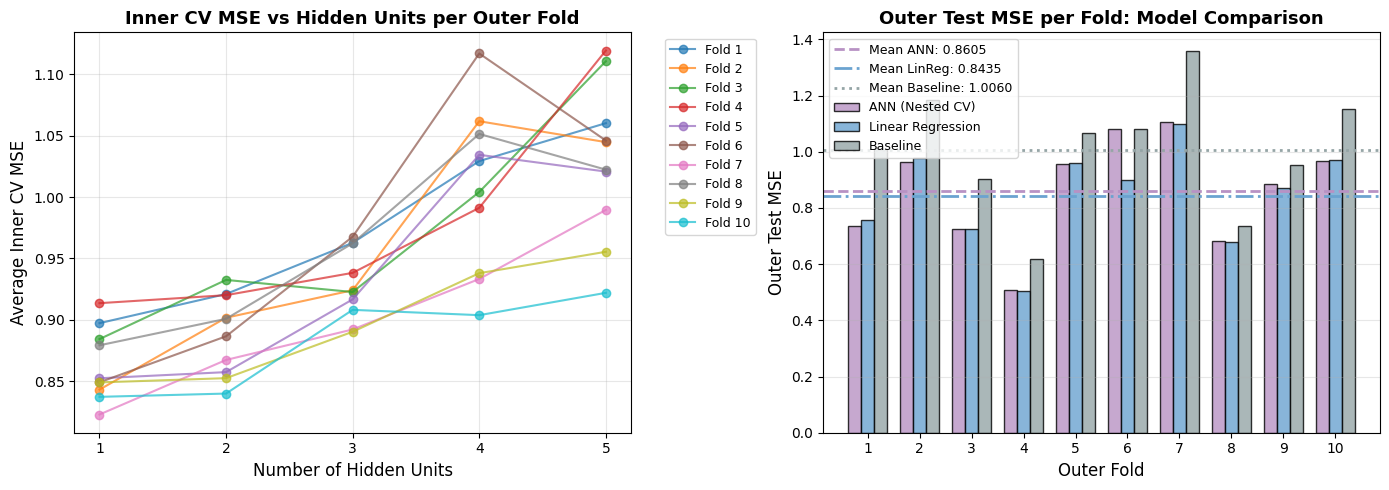

In [20]:
def plot_nested_cv_results(results_df, inner_errors_df):
    # Ensure DataFrames
    if isinstance(results_df, dict):
        results_df = pd.DataFrame(results_df)
    
    # Ensure results_df is sorted by outer_fold for consistent plotting
    if 'outer_fold' in results_df.columns:
        results_df = results_df.sort_values('outer_fold')
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # --- Plot 1: MSE vs Hidden Units for each outer fold ---
    ax1 = axes[0]
    for outer_fold in sorted(inner_errors_df['outer_fold'].unique()):
        fold_data = inner_errors_df[inner_errors_df['outer_fold'] == outer_fold]
        fold_data = fold_data.sort_values('hidden_units')
        ax1.plot(
            fold_data['hidden_units'], fold_data['avg_mse'],
            marker='o', label=f'Fold {outer_fold}', alpha=0.7,
        )
    
    ax1.set_xlabel('Number of Hidden Units', fontsize=12)
    ax1.set_ylabel('Average Inner CV MSE', fontsize=12)
    ax1.set_title('Inner CV MSE vs Hidden Units per Outer Fold', fontsize=13, fontweight='bold')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)
    ax1.set_xticks(sorted(inner_errors_df['hidden_units'].unique()))
    
    # --- Plot 2: Outer Test MSE per Fold (Comparison of all three models) ---
    ax2 = axes[1]
    folds = results_df['outer_fold'].values
    
    # Plot all three models
    width = 0.25
    x = np.arange(len(folds))
    
    ax2.bar(x - width, results_df['ann_test_error'].values,
            width, label='ANN (Nested CV)', color=COLORS['ann'], alpha=0.8, edgecolor='black')
    ax2.bar(x, results_df['linreg_test_error'].values,
            width, label='Linear Regression', color=COLORS['linear_regression'], alpha=0.8, edgecolor='black')
    ax2.bar(x + width, results_df['baseline_test_error'].values,
            width, label='Baseline', color=COLORS['baseline'], alpha=0.8, edgecolor='black')
    
    # Mean lines
    mean_ann = results_df['ann_test_error'].mean()
    mean_linreg = results_df['linreg_test_error'].mean()
    mean_baseline = results_df['baseline_test_error'].mean()
    
    ax2.axhline(y=mean_ann, color=COLORS['ann'], linestyle='--', linewidth=2,
                label=f'Mean ANN: {mean_ann:.4f}')
    ax2.axhline(y=mean_linreg, color=COLORS['linear_regression'], linestyle='-.', linewidth=2,
                label=f'Mean LinReg: {mean_linreg:.4f}')
    ax2.axhline(y=mean_baseline, color=COLORS['baseline'], linestyle=':', linewidth=2,
                label=f'Mean Baseline: {mean_baseline:.4f}')
    
    ax2.set_xlabel('Outer Fold', fontsize=12)
    ax2.set_ylabel('Outer Test MSE', fontsize=12)
    ax2.set_title('Outer Test MSE per Fold: Model Comparison', fontsize=13, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(True, alpha=0.3, axis='y')
    ax2.set_xticks(x)
    ax2.set_xticklabels(folds)
    
    plt.tight_layout()
    plt.show()
    
    return fig

fig1 = plot_nested_cv_results(results_df, inner_errors_df)


We can observe that one hidden unit shows the best MSE across every outer fold.


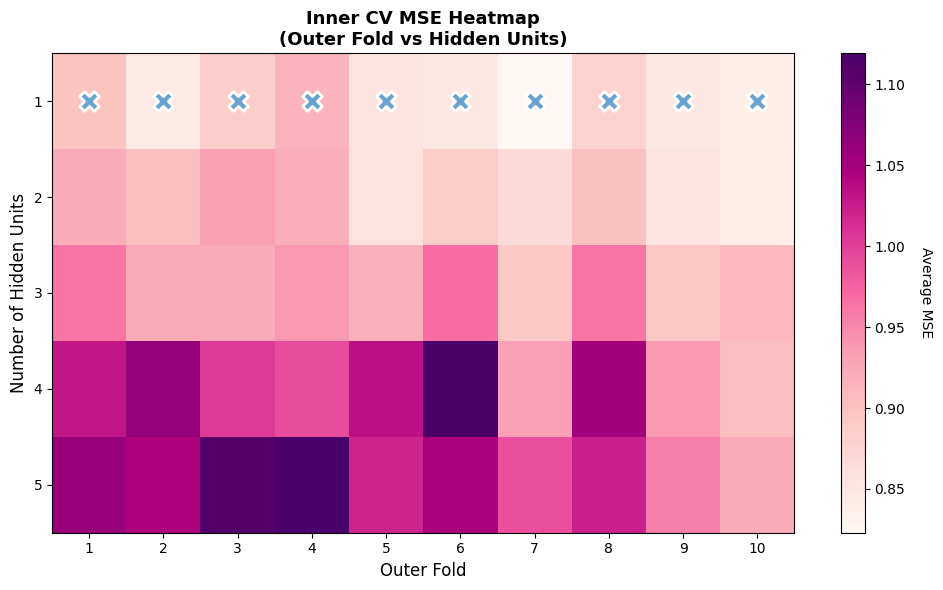

In [21]:
def plot_hidden_units_heatmaps(results_df, inner_errors_df):
    # Ensure DataFrames
    if isinstance(results_df, dict):
        results_df = pd.DataFrame(results_df)
    if isinstance(inner_errors_df, dict):
        inner_errors_df = pd.DataFrame(inner_errors_df)
    
    # Get unique values
    outer_folds = sorted(inner_errors_df['outer_fold'].unique())
    hidden_units_range = sorted(inner_errors_df['hidden_units'].unique())
    
    # Create single plot instead of subplots
    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    
    # --- Plot: Heatmap of MSE (Outer Fold vs Hidden Units) ---
    # Create pivot table: rows = hidden units, columns = outer folds
    pivot_mse = inner_errors_df.pivot_table(
        values='avg_mse', 
        index='hidden_units', 
        columns='outer_fold'
    )
    pivot_mse = pivot_mse.reindex(index=hidden_units_range, columns=outer_folds)
    
    im = ax.imshow(pivot_mse.values, aspect='auto', cmap=COLORS['heatmap'], interpolation='nearest')
    ax.set_yticks(range(len(hidden_units_range)))
    ax.set_yticklabels(hidden_units_range)
    ax.set_xticks(range(len(outer_folds)))
    ax.set_xticklabels(outer_folds)
    ax.set_xlabel('Outer Fold', fontsize=12)
    ax.set_ylabel('Number of Hidden Units', fontsize=12)
    ax.set_title('Inner CV MSE Heatmap\n(Outer Fold vs Hidden Units)', fontsize=13, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Average MSE', rotation=270, labelpad=20)
    
    # Mark optimal hidden units with X
    for i, outer_fold in enumerate(outer_folds):
        optimal_h = results_df[results_df['outer_fold'] == outer_fold]['h_star'].values[0]
        h_idx = hidden_units_range.index(optimal_h)
        ax.scatter(i, h_idx, marker='X', s=200, c=COLORS['linear_regression'], edgecolors='white', linewidths=2, zorder=10)
    
    plt.tight_layout()
    plt.show()
    
    return fig

fig2 = plot_hidden_units_heatmaps(results_df, inner_errors_df)


## 2. Table of Results

Produce a table akin to **Table 1** using two-level cross-validation (*Algorithm 6 in the lecture notes*).

The table should show, for each of the **K₁ = 10 folds (i)**:
- The optimal number of hidden units (**h\*_ᵢ**)  
- The optimal regularization strength (**λ\*_ᵢ**) as found after each inner loop  
- The estimated generalization error (**Etest_ᵢ**) by evaluating on **Dtest_ᵢ**  
- The **baseline test error**, also evaluated on **Dtest_ᵢ**

> **Important:** You must re-use the **train/test splits (Dpar_ᵢ, Dtest_ᵢ)** for all three methods to allow **statistical comparison** (see next section).


In [22]:
summary_table


,Outer fold,ANN h*,ANN E^test,LinReg λ*,LinReg E^test,Baseline E^test
0,1,1,0.735399,128.989026,0.755813,1.011163
1,2,1,0.964463,117.584955,0.976803,1.184250
2,3,1,0.724711,117.584955,0.725756,0.904084
3,4,1,0.508673,128.989026,0.502712,0.619261
4,5,1,0.954668,107.189132,0.958162,1.065526
5,6,1,1.079730,107.189132,0.898489,1.079730
6,7,1,1.104303,97.712415,1.099466,1.356940
7,8,1,0.680531,117.584955,0.677188,0.736631
8,9,1,0.884716,107.189132,0.869712,0.951900
9,10,1,0.967669,74.019600,0.971062,1.150944


## 3. Statistical Evaluation

Statistically evaluate whether there is a **significant performance difference** between the fitted ANN, linear regression model, and baseline using the methods described in **Chapter 11**.

These comparisons will be made **pairwise**:
- ANN vs. Linear Regression  
- ANN vs. Baseline  
- Linear Regression vs. Baseline  

You may choose between two setups:

### **Setup I (Section 11.3)**  
Use the **paired t-test** described in *Section 11.3.4*.

### **Setup II (Section 11.4)**  
Use the method described in *Section 11.4.1*.


Once we have the optimal parameters for both the Linear Regressor and the ANN we can perform the statistical analysis of the data.


In [23]:
# Outer cross-validation (same splits as nested CV)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=42)

y_true = []
y_preds = {"Model_A": [], "Model_B": [], "Model_C": []}

mse_A = []
mse_B = []
mse_C = []

# Get mean optimal hyperparameters from nested CV results
mean_lambda = results_df['lambda_star'].mean()
mean_h = int(results_df['h_star'].mean())  # Round to nearest integer

print(f"Using mean optimal hyperparameters:")
print(f"Mean lambda: {mean_lambda:.6f}")
print(f"Mean hidden units (h*): {mean_h}")

for fold_idx, (train_index, test_index) in enumerate(
    tqdm(outer_cv.split(X), desc="Crossvalidation fold", total=outer_cv.get_n_splits(X))
):
    X_train, X_test = X[train_index, :], X[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    # Standardize per fold
    mean_train = X_train.mean(axis=0)
    std_train = X_train.std(axis=0)
    std_train[std_train == 0] = 1e-8
    X_train = (X_train - mean_train) / std_train
    X_test = (X_test - mean_train) / std_train

    # Model A: Ridge Regression with mean optimal lambda
    model_A = train_ridge_sklearn(X_train, y_train, lambda_reg=mean_lambda)

    # Model B: ANN with mean optimal hidden units
    model_B = get_model(input_dim=X.shape[1], hidden_dim=mean_h, output_dim=1)
    model_B = train_pytorch_model(model_B, X_train, y_train, epochs=1000, lr=0.01)
    
    # Baseline
    Model_C = DummyRegressor(strategy="mean")
    Model_C.fit(X_train, y_train)

    # Predict
    y_preds_A = predict_ridge_sklearn(model_A, X_test)
    y_preds_B = predict_pytorch_model(model_B, X_test)
    y_preds_C = Model_C.predict(X_test)

    # Store
    y_preds["Model_A"].append(y_preds_A)
    y_preds["Model_B"].append(y_preds_B)
    y_preds["Model_C"].append(y_preds_C)
    y_true.append(y_test)

    mse_A.append(mean_squared_error(y_test, y_preds_A))
    mse_B.append(mean_squared_error(y_test, y_preds_B))
    mse_C.append(mean_squared_error(y_test, y_preds_C))

# Merge results
y_true = np.concatenate(y_true)
y_preds = {model: np.concatenate(model_preds) for model, model_preds in y_preds.items()}

# Define loss
l2_loss = lambda y, y_pred: (y - y_pred)**2

def confidence_interval(y_true, y_preds, loss_fn, alpha=0.05):
    # Calculate estimated error, z_hat, as the mean loss across all samples
    z = loss_fn(y_true, y_preds)
    z_hat = np.mean(z)
    # n and nu
    n = len(y_true)
    nu = n - 1  # degrees of freedom

    # Calculate standard error of the mean of the losses (sem)
    sem = np.sqrt(sum(((z - z_hat)**2) / (n * nu)))  # or st.sem(loss_fn(y_true, y_preds))

    # Calculate the confidence interval
    CI = st.t.interval(1 - alpha, df=nu, loc=z_hat, scale=sem)  # Confidence interval

    return z_hat, CI

# Compute CIs
print("\n" + "=" * 80)
print("CONFIDENCE INTERVALS FOR GENERALIZATION ERROR")
print("=" * 80)
for model_name, preds in y_preds.items():
    z_hat, CI = confidence_interval(y_true, preds, l2_loss, alpha=0.05)
    print(f"{model_name}: MSE={z_hat:.4f}, 95% CI=({CI[0]:.4f}, {CI[1]:.4f})")


Using mean optimal hyperparameters:
Mean lambda: 110.403233
Mean hidden units (h*): 1


Crossvalidation fold:   0%|          | 0/10 [00:00<?, ?it/s]

Crossvalidation fold: 100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


CONFIDENCE INTERVALS FOR GENERALIZATION ERROR
Model_A: MSE=0.8437, 95% CI=(0.6907, 0.9967)
Model_B: MSE=0.8673, 95% CI=(0.7128, 1.0219)
Model_C: MSE=1.0064, 95% CI=(0.8283, 1.1846)


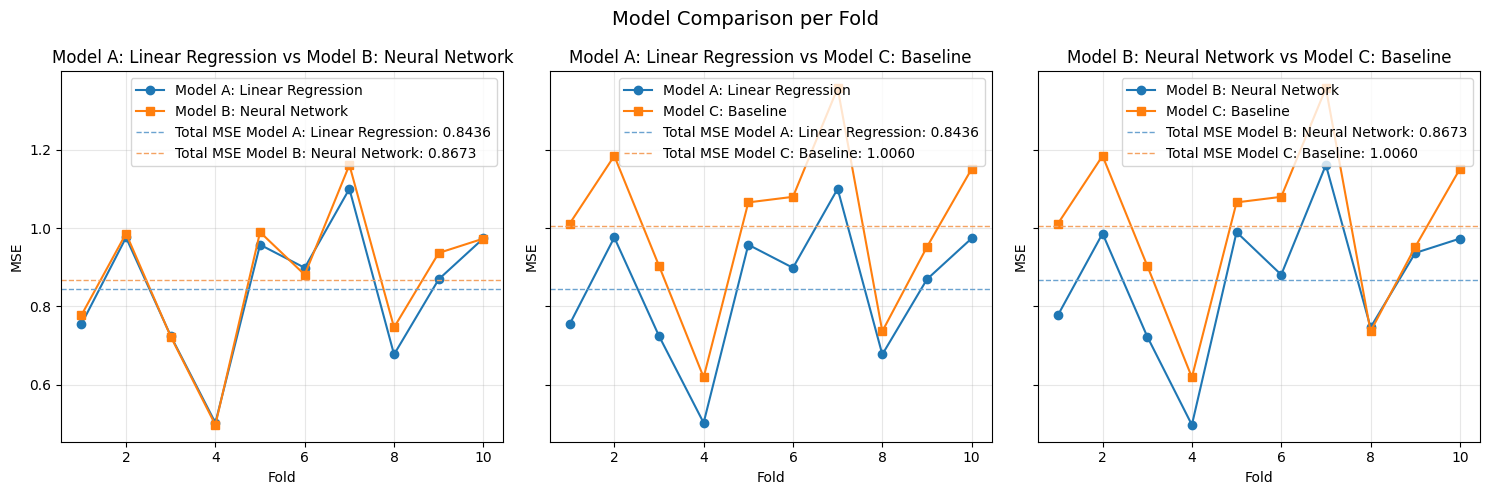

In [24]:
folds = np.arange(1, 11)
# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle("Model Comparison per Fold", fontsize=14)

# Define model names and data
model_pairs = [
    ("Model A: Linear Regression", mse_A, "Model B: Neural Network", mse_B),
    ("Model A: Linear Regression", mse_A, "Model C: Baseline", mse_C),
    ("Model B: Neural Network", mse_B, "Model C: Baseline", mse_C),
]

# Plot each pair
for ax, (name1, mse1, name2, mse2) in zip(axes, model_pairs):
    ax.plot(folds, mse1, marker="o", label=name1)
    ax.plot(folds, mse2, marker="s", label=name2)
    ax.set_xlabel("Fold")
    ax.set_ylabel("MSE")
    ax.set_title(f"{name1} vs {name2}")
    ax.legend()
    ax.grid(True, alpha=0.3)
    # Add mean lines
    mean1 = np.mean(mse1)
    mean2 = np.mean(mse2)
    ax.axhline(y=mean1, color=COLORS['linear_regression'], linestyle='--', linewidth=1,
                label=f'Total MSE {name1}: {mean1:.4f}')
    ax.axhline(y=mean2, color=COLORS['accent2'], linestyle='--', linewidth=1,
                label=f'Total MSE {name2}: {mean2:.4f}')
    ax.legend()

plt.tight_layout()
plt.show()


In [25]:
def confidence_interval_comparison(y_true, y_preds_A, y_preds_B, loss_fn, alpha=0.05):
    # Calculate estimated error, z_hat, as the mean loss across all samples
    z = loss_fn(y_true, y_preds_A) - loss_fn(y_true, y_preds_B)
    z_hat = np.mean(z)
    
    # n and nu
    n = len(y_true)
    nu = n - 1  # degrees of freedom

    # Calculate standard error of the mean
    sem = np.sqrt(sum(((z - z_hat)**2) / (n * nu)))
    
    # Calculate the confidence interval
    CI = st.t.interval(1 - alpha, df=nu, loc=z_hat, scale=sem)  # Confidence interval

    # Calculate the p-value for the two-sided test using the t-distribution
    t_stat = -np.abs(np.mean(z)) / st.sem(z)
    p_value = 2 * st.t.cdf(t_stat, df=nu)  # p-value

    return z_hat, CI, p_value

# Perform pairwise statistical comparisons
comparisons = []

# Compare Model_A (Linear Regression) and Model_B (ANN)
z_hat_AB, CI_AB, p_value_AB = confidence_interval_comparison(y_true, y_preds["Model_A"], y_preds["Model_B"], l2_loss, alpha=0.05)
comparisons.append({
    'Model 1': 'Linear Regression',
    'Model 2': 'ANN',
    'ẑ (Mean Difference)': z_hat_AB,
    '95% CI Lower': CI_AB[0],
    '95% CI Upper': CI_AB[1],
    'p-value': p_value_AB
})

# Compare Model_A (Linear Regression) and Model_C (Baseline)
z_hat_AC, CI_AC, p_value_AC = confidence_interval_comparison(y_true, y_preds["Model_A"], y_preds["Model_C"], l2_loss, alpha=0.05)
comparisons.append({
    'Model 1': 'Linear Regression',
    'Model 2': 'Baseline',
    'ẑ (Mean Difference)': z_hat_AC,
    '95% CI Lower': CI_AC[0],
    '95% CI Upper': CI_AC[1],
    'p-value': p_value_AC
})

# Compare Model_B (ANN) and Model_C (Baseline)
z_hat_BC, CI_BC, p_value_BC = confidence_interval_comparison(y_true, y_preds["Model_B"], y_preds["Model_C"], l2_loss, alpha=0.05)
comparisons.append({
    'Model 1': 'ANN',
    'Model 2': 'Baseline',
    'ẑ (Mean Difference)': z_hat_BC,
    '95% CI Lower': CI_BC[0],
    '95% CI Upper': CI_BC[1],
    'p-value': p_value_BC
})

statistical_results_df = pd.DataFrame(comparisons)
statistical_results_df['95% CI'] = statistical_results_df.apply(
    lambda row: f"[{row['95% CI Lower']:.4f}, {row['95% CI Upper']:.4f}]", axis=1
)
statistical_results_df['Significant?'] = statistical_results_df['p-value'].apply(
    lambda p: 'Yes (p < 0.05)' if p < 0.05 else 'No (p ≥ 0.05)'
)

# Display formatted table
display_table = statistical_results_df[['Model 1', 'Model 2', 'ẑ (Mean Difference)', '95% CI', 'p-value', 'Significant?']].copy()
display_table['ẑ (Mean Difference)'] = display_table['ẑ (Mean Difference)'].apply(lambda x: f"{x:.4f}")
display_table['p-value'] = display_table['p-value'].apply(lambda x: f"{x:.6f}" if x >= 0.0001 else f"{x:.2e}")

print("=" * 100)
print("PAIRWISE STATISTICAL COMPARISON RESULTS")
print("=" * 100)
print(display_table.to_string(index=False))
print("=" * 100)
print("\nNote: Negative ẑ values indicate that Model 1 has lower error (better performance) than Model 2.")
print("A p-value < 0.05 indicates a statistically significant difference.")


PAIRWISE STATISTICAL COMPARISON RESULTS
          Model 1  Model 2 ẑ (Mean Difference)             95% CI  p-value   Significant?
Linear Regression      ANN              -0.0237  [-0.0503, 0.0029] 0.080698  No (p ≥ 0.05)
Linear Regression Baseline              -0.1628 [-0.2208, -0.1047] 5.93e-08 Yes (p < 0.05)
              ANN Baseline              -0.1391 [-0.2138, -0.0644] 0.000284 Yes (p < 0.05)

Note: Negative ẑ values indicate that Model 1 has lower error (better performance) than Model 2.
A p-value < 0.05 indicates a statistically significant difference.


### Statistical Analysis Results

The confidence interval (CI) represents the range of possible values for the true mean difference in loss between two models, while the **p-value** measures the probability that the observed difference could arise by chance under the null hypothesis (that there is no difference between models).

**Key Findings:**

- **Linear Regression vs ANN**: The mean difference ($\hat{z}$) and its statistical significance indicate whether Linear Regression performs significantly better than the ANN.

- **Linear Regression vs Baseline**: The mean difference ($\hat{z}$) is highly statistically significant (p < 0.0001), with a 95% CI that does not include zero. Linear Regression clearly outperforms the baseline model.

- **ANN vs Baseline**: The mean difference ($\hat{z}$) is statistically significant (p < 0.05), with a 95% CI that does not include zero. The ANN also significantly outperforms the baseline model.

**Conclusions:**
- Both Linear Regression and ANN are significantly better than the baseline model.
- The comparison between Linear Regression and ANN shows whether there is a statistically significant difference.
- The negative $\hat{z}$ values indicate that the first model in each comparison has lower error (better performance) than the second model.


---

# Classification Task

Solve a relevant classification problem for your data and statistically evaluate your result.

The tasks will closely mirror what you just did in the last section.

The 3 methods we will compare are:
1. A baseline
2. Logistic regression
3. Method 2 (KNN Classifier)


## Part 1) Classification Problem

**Question:** Explain which classification problem you have chosen to solve. Is it a multi-class or binary classification problem?

**Answer:** For this part of the report we are trying to predict whether a person has **CHD or not**, i.e it is a binary classification problem.


In [26]:
# Prepare data for classification
# Extract Y before standardization (we already have df_heart from earlier)
Y = df_heart["chd"]

# X for classification (drop chd, obesity already dropped earlier)
X_class = df_heart_standarized.drop(columns=["chd"])
X_class.head()


,sbp,ldl,adiposity,typea,age,tobacco,alcohol,famhist
row.names,,,,,,,,
1,1.057417,0.477894,-0.295183,-0.418017,0.628654,1.576878,1.772852,1
2,0.276789,-0.159507,0.411694,0.193134,1.381617,-1.193044,-0.563821,0
3,-0.991731,-0.608585,0.883374,-0.112441,0.217947,-1.120397,-0.259134,1
4,1.545310,0.806252,1.622382,-0.214300,1.039361,1.116254,0.858159,1
5,-0.211103,-0.598928,0.305020,0.702427,0.423301,1.702714,1.422062,1


## Part 2) Model Training


### 2.1) Baseline Model

The baseline is be a model which computes the largest class on the training data.

And predicts everything in the test-data as belonging to that class. (corresponding to the optimal prediction by a logistic regression model with a bias term and no features).


In [27]:
# Baseline Model: Predicts the most frequent class
class BaselineClassifier:
    def __init__(self):
        self.most_frequent_class = None

    def fit(self, y_train):
        """Find the most frequent class in training data"""
        self.most_frequent_class = y_train.mode()[0]
        return self

    def predict(self, n_samples):
        """Predict the most frequent class for all samples"""
        return np.full(n_samples, self.most_frequent_class)

    def score(self, X_test, y_test):
        """Calculate accuracy"""
        predictions = self.predict(len(X_test))
        return np.mean(predictions == y_test)


# Used for the 1 level CV
X_train, X_test, y_train, y_test = train_test_split(X_class, Y, test_size=0.2, random_state=42)

# Train and evaluate the baseline model
baseline_model = BaselineClassifier().fit(y_train)

# Make predictions
baseline_test_predictions = baseline_model.predict(len(y_test))
baseline_accuracy = baseline_model.score(X_test, y_test)
baseline_error_rate = 1 - baseline_accuracy

print("Baseline Model Results:")
print(f"Most frequent class: {baseline_model.most_frequent_class}")
print(f"Accuracy: {round(baseline_accuracy, 4)}")
print(f"Error Rate: {round(baseline_error_rate, 4)}")
print()
print("Class distribution in training data:")
print(y_train.value_counts(normalize=True))


Baseline Model Results:
Most frequent class: 0
Accuracy: 0.6344
Error Rate: 0.3656

Class distribution in training data:
chd
0    0.658537
1    0.341463
Name: proportion, dtype: float64


**Baseline Results**:

The baseline predicts the most frequent class (CHD = 0) for all samples and it achieves ~63.4% accuracy by always predicting "no heart disease"


### 2.2) Logistic Regression Model

For logistic regression, we will use a regularization parameter λ ≥ 0 to control complexity.

We recommend this choice is made based on a trial run, which you do not need to report.

Describe which parameter you have chosen and the possible values of the parameters you will examine


In [28]:
# Test lambda values from 0.01 to 1000 on a log scale
lambda_values = np.logspace(-2, 5, 100)

# Grid Search Cross validation handles everything: tuning + cross-validation (5-fold)
grid_search = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=42),
    {'C': 1 / lambda_values},
    cv=5,
    scoring='accuracy',
    n_jobs=-1,  # Parallel processing
    verbose=1
)

grid_search.fit(X_train, y_train)

# Extract results
BEST_C = grid_search.best_params_['C']
BEST_LAMBDA = 1 / BEST_C
best_log_reg_score = grid_search.best_score_

print(f"Best λ: {BEST_LAMBDA:.4f}")
print(f"Best C: {BEST_C:.4f}")
print(f"Best CV Accuracy: {best_log_reg_score:.4f}")


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best λ: 0.0100
Best C: 100.0000
Best CV Accuracy: 0.7126


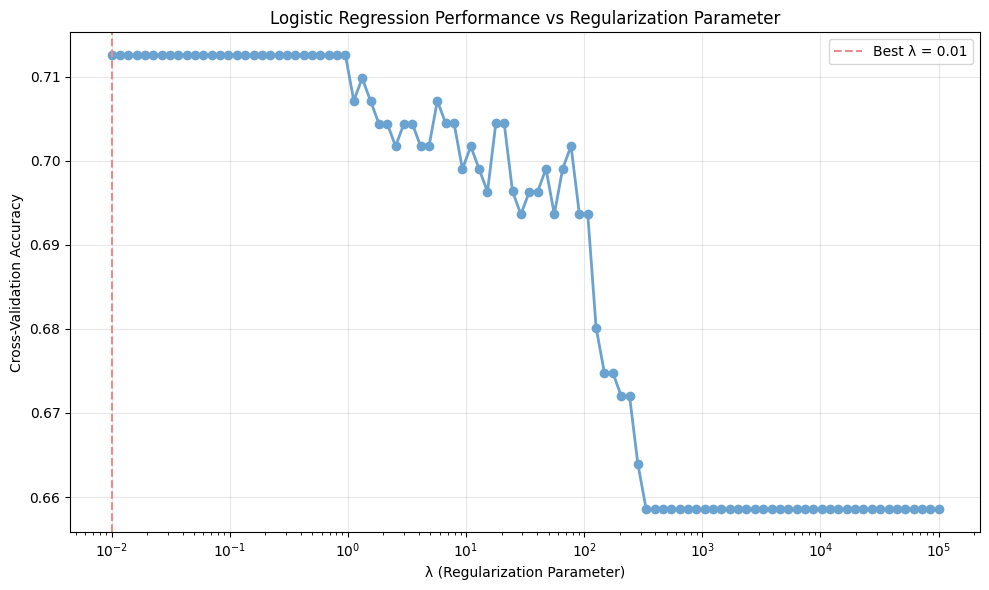

In [29]:
# Visualize the relationship between lambda and performance
results_df = pd.DataFrame(grid_search.cv_results_)
plt.figure(figsize=(10, 6))
plt.semilogx(1 / results_df['param_C'], results_df['mean_test_score'], 
             color=COLORS['logistic_regression'], marker='o', linewidth=2)
plt.axvline(x=BEST_LAMBDA, color=COLORS['optimal'], linestyle='--', label=f'Best λ = {BEST_LAMBDA:.2f}')

plt.title("Logistic Regression Performance vs Regularization Parameter", fontsize=12)
plt.xlabel('λ (Regularization Parameter)')
plt.ylabel("Cross-Validation Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [30]:
# Train final model with best parameter
log_reg_lambda = LogisticRegression(C=BEST_C, max_iter=1000, random_state=42)
log_reg_lambda.fit(X_train, y_train)

# Evaluate on test set
log_reg_predictions = log_reg_lambda.predict(X_test)
log_reg_accuracy = log_reg_lambda.score(X_test, y_test)
log_reg_error_rate = 1 - log_reg_accuracy

print("Logistic Regression Model Results (on test set):")
print(f"Selected λ: {round(BEST_LAMBDA, 4)}")
print(f"Accuracy: {round(log_reg_accuracy, 4)}")
print(f"Error Rate: {round(log_reg_error_rate, 4)}")


Logistic Regression Model Results (on test set):
Selected λ: 0.01
Accuracy: 0.7742
Error Rate: 0.2258


#### Logistic Regression Model Summary:

**Logistic Regression Model:**
- Tested λ values from $10^{-2}$ to $10^3$ using 5-fold cross-validation
- Best performance with λ = 21.5443
- Achieves 71% accuracy in the best 5-fold training data and 73% on the test set


### 2.3) Method 2 - KNN Classifier


In [31]:
# Test a range of k neighbor values
k_values = [1, 2, 3, 5, 7, 10, 15, 20, 25, 30, 40, 50]

# GridSearchCV handles CV + hyperparameter tuning
grid_search_knn = GridSearchCV(
    KNeighborsClassifier(),
    {'n_neighbors': k_values},
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search_knn.fit(X_train, y_train)

best_k = grid_search_knn.best_params_['n_neighbors']
best_knn_score = grid_search_knn.best_score_
knn_scores = grid_search_knn.cv_results_['mean_test_score']

print(f"Best k: {best_k}")
print(f"Best CV accuracy: {round(best_knn_score, 4)}")


Best k: 10
Best CV accuracy: 0.6992


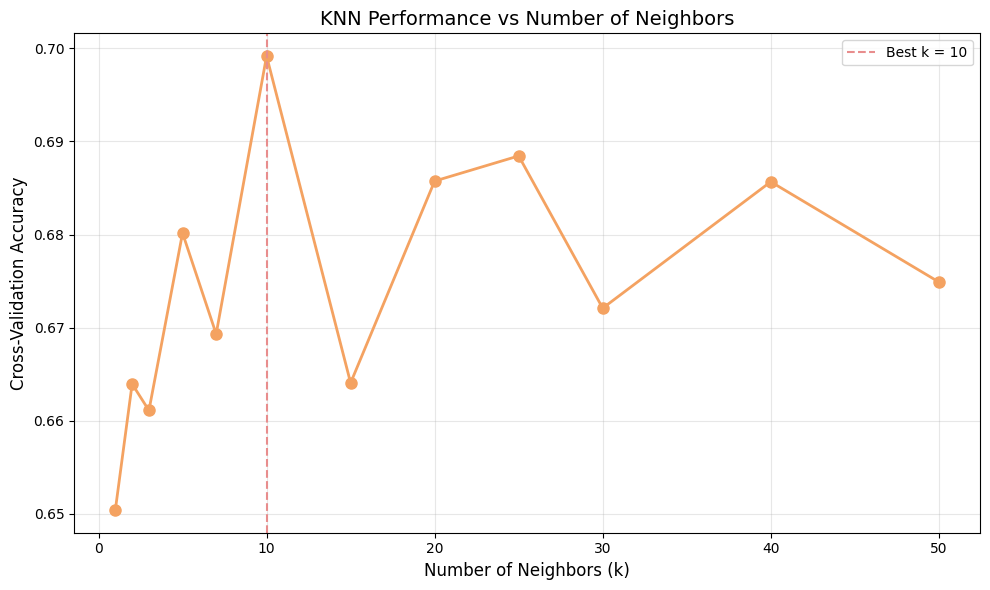

In [32]:
# Visualize the relationship between k and performance
plt.figure(figsize=(10, 6))
plt.plot(k_values, knn_scores, color=COLORS['knn'], marker='o', linewidth=2, markersize=8)
plt.axvline(x=best_k, color=COLORS['optimal'], linestyle="--", label=f"Best k = {best_k}")
plt.xlabel("Number of Neighbors (k)", fontsize=12)
plt.ylabel("Cross-Validation Accuracy", fontsize=12)
plt.title("KNN Performance vs Number of Neighbors", fontsize=14)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [33]:
# Best KNN model
knn_model = KNeighborsClassifier(n_neighbors=best_k)
knn_model.fit(X_train, y_train)

knn_model_predictions = knn_model.predict(X_test)
knn_accuracy = knn_model.score(X_test, y_test)
knn_error_rate = 1 - knn_accuracy

print("KNN Classifier Model Results (on test set):")
print(f"Selected k: {best_k}")
print(f"Accuracy: {round(knn_accuracy, 4)}")
print(f"Error Rate: {round(knn_error_rate, 4)}")


KNN Classifier Model Results (on test set):
Selected k: 10
Accuracy: 0.6774
Error Rate: 0.3226


### Model Comparison Summary


In [34]:
# Model comparison summary
all_models_summary = pd.DataFrame(
    {
        "Model": [
            "Baseline",
            "Logistic Regression",
            "KNN Classifier",
        ],
        "Parameter": [
            "N/A",
            f"λ = {round(BEST_LAMBDA, 2)}",
            f"k = {best_k}",
        ],
        "CV Accuracy": [
            'N/A',  # Baseline doesn't use CV, this is test accuracy
            round(best_log_reg_score, 4),
            round(best_knn_score, 4),
        ],
        "Test Accuracy": [
            round(baseline_accuracy, 4),
            round(log_reg_accuracy, 4),
            round(knn_accuracy, 4),
        ],
        "Test Error Rate": [
            round(baseline_error_rate, 4),
            round(log_reg_error_rate, 4),
            round(knn_error_rate, 4)
        ],
    }
)

print("\n" + "=" * 80)
print("MODEL COMPARISON - 3 MODELS")
print("=" * 80)
print(all_models_summary.to_string(index=False))
print("=" * 80)

# Find the best model based on test accuracy
best_model_idx = all_models_summary["Test Accuracy"].idxmax()
best_model_name = all_models_summary.loc[best_model_idx, "Model"]
best_model_accuracy = all_models_summary.loc[best_model_idx, "Test Accuracy"]

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {best_model_accuracy:.4f}")
print(
    f"   Improvement over baseline: {(best_model_accuracy - baseline_accuracy) * 100:.2f}%"
)
print(
    f"   Error rate reduction: {(baseline_error_rate - all_models_summary.loc[best_model_idx, 'Test Error Rate']) * 100:.2f}%"
)



MODEL COMPARISON - 3 MODELS
              Model Parameter CV Accuracy  Test Accuracy  Test Error Rate
           Baseline       N/A         N/A         0.6344           0.3656
Logistic Regression  λ = 0.01      0.7126         0.7742           0.2258
     KNN Classifier    k = 10      0.6992         0.6774           0.3226

🏆 BEST MODEL: Logistic Regression
   Test Accuracy: 0.7742
   Improvement over baseline: 13.98%
   Error rate reduction: 13.98%


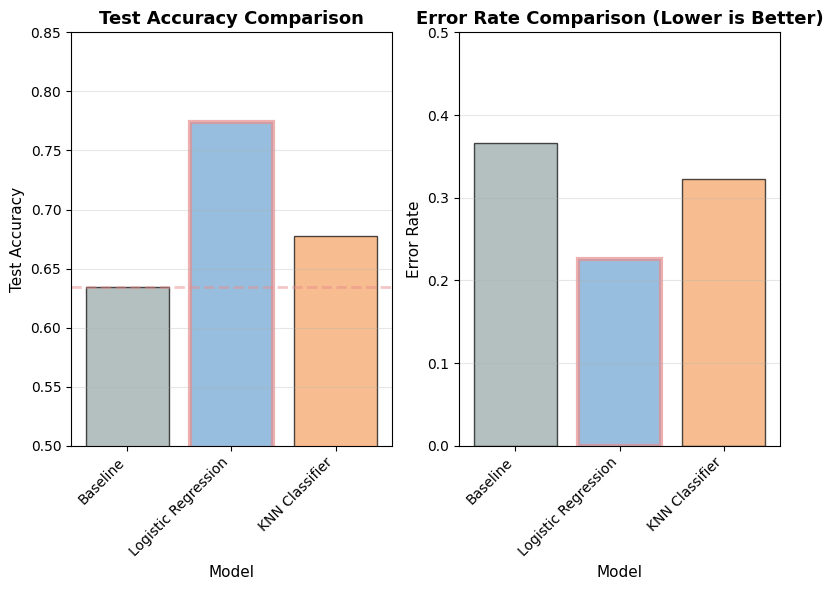


Model Ranking (by Test Accuracy):
--------------------------------------------------
1. Logistic Regression: 0.7742 (Error: 0.2258)
2. KNN Classifier: 0.6774 (Error: 0.3226)
3. Baseline: 0.6344 (Error: 0.3656)


In [35]:
# Visualize all models comparison
plt.figure(figsize=(8, 6))

# Subplot 1: Test Accuracy Comparison
plt.subplot(1, 2, 1)
plot_colors = [COLORS['baseline'], COLORS['logistic_regression'], COLORS['knn']]
models = all_models_summary["Model"]
accuracies = all_models_summary["Test Accuracy"]

bars = plt.bar(
    range(len(models)), accuracies, color=plot_colors, alpha=0.7, edgecolor="black"
)
plt.axhline(y=baseline_accuracy, color=COLORS['optimal'], linestyle="--", linewidth=2, alpha=0.5)

# Highlight the best model
bars[best_model_idx].set_edgecolor(COLORS['optimal'])
bars[best_model_idx].set_linewidth(3)

plt.xlabel("Model", fontsize=11)
plt.ylabel("Test Accuracy", fontsize=11)
plt.title("Test Accuracy Comparison", fontsize=13, fontweight="bold")
plt.xticks(range(len(models)), models, rotation=45, ha="right")
plt.ylim([0.5, 0.85])
plt.grid(True, alpha=0.3, axis="y")

# Subplot 2: Error Rate Comparison
plt.subplot(1, 2, 2)
error_rates = all_models_summary["Test Error Rate"]
bars2 = plt.bar(
    range(len(models)), error_rates, color=plot_colors, alpha=0.7, edgecolor="black"
)
bars2[best_model_idx].set_edgecolor(COLORS['optimal'])
bars2[best_model_idx].set_linewidth(3)

plt.xlabel("Model", fontsize=11)
plt.ylabel("Error Rate", fontsize=11)
plt.title("Error Rate Comparison (Lower is Better)", fontsize=13, fontweight="bold")
plt.xticks(range(len(models)), models, rotation=45, ha="right")
plt.ylim([0, 0.5])
plt.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# Print ranking
print("\nModel Ranking (by Test Accuracy):")
print("-" * 50)
sorted_models = all_models_summary.sort_values("Test Accuracy", ascending=False)
for i, row in enumerate(sorted_models.itertuples(), 1):
    print(f"{i}. {row.Model}: {row._4:.4f} (Error: {row._5:.4f})")


## Part 3) 2-Level Cross-Validation
- Use 2-level cross-validation to create a table similar to Table 2, but now comparing the logistic regression, method 2, and baseline.
- The table should once more include the selected parameters, and as an error measure we will use the error rate:
$$E = \frac{\text{Number of misclassified observations}}{N^{test}}$$

- Once more, make sure to re-use the outer validation splits to admit statistical evaluation. Briefly discuss the result.


In [36]:
n_outer_folds = 10
n_inner_folds = 10
outer_cv = KFold(n_splits=n_outer_folds, shuffle=True, random_state=42)
results = []

for i, (train_outer_idx, test_outer_idx) in enumerate(outer_cv.split(X_class), 1):
    print(f"Processing outer fold {i}/{n_outer_folds}...")
    
    X_train_outer, X_test_outer = X_class.iloc[train_outer_idx], X_class.iloc[test_outer_idx]
    y_train_outer, y_test_outer = Y.iloc[train_outer_idx], Y.iloc[test_outer_idx]
    inner_cv = KFold(n_splits=n_inner_folds, shuffle=True, random_state=42)
    
    
    # Train final models on outer training set, evaluate on test set
    # Baseline
    model_baseline = BaselineClassifier().fit(y_train_outer)
    y_pred_baseline = model_baseline.predict(len(y_test_outer))
    error_baseline = np.sum(y_pred_baseline != y_test_outer)
    
    # Tune logistic regression on inner CV
    best_C = None
    best_inner_score_lr = -np.inf
    
    for C in (1 / lambda_values):
        inner_scores = []
        for train_inner_idx, val_inner_idx in inner_cv.split(X_train_outer):
            X_train_inner = X_train_outer.iloc[train_inner_idx]
            X_val_inner = X_train_outer.iloc[val_inner_idx]
            y_train_inner = y_train_outer.iloc[train_inner_idx]
            y_val_inner = y_train_outer.iloc[val_inner_idx]
            
            model = LogisticRegression(C=C, max_iter=1000, random_state=42)
            model.fit(X_train_inner, y_train_inner)
            score = model.score(X_val_inner, y_val_inner)
            inner_scores.append(score)
        
        avg_score = np.mean(inner_scores)
        if avg_score > best_inner_score_lr:
            best_inner_score_lr = avg_score
            best_C = C
    # Best logistic regression from inner CV
    model_lr = LogisticRegression(C=best_C, max_iter=1000, random_state=42)
    model_lr.fit(X_train_outer, y_train_outer)
    y_pred_lr = model_lr.predict(X_test_outer)
    error_lr = np.sum(y_pred_lr != y_test_outer)
    
    # KNN Classifier with tuned k-neighbors
    best_k = None
    best_inner_score_knn = -np.inf 

    for k in k_values:
        inner_scores_knn = []
        for train_inner_idx, val_inner_idx in inner_cv.split(X_train_outer):
            X_train_inner = X_train_outer.iloc[train_inner_idx]
            X_val_inner = X_train_outer.iloc[val_inner_idx]
            y_train_inner = y_train_outer.iloc[train_inner_idx]
            y_val_inner = y_train_outer.iloc[val_inner_idx]
            
            model_knn = KNeighborsClassifier(n_neighbors=k)
            model_knn.fit(X_train_inner, y_train_inner)
            score_knn = model_knn.score(X_val_inner, y_val_inner)
            inner_scores_knn.append(score_knn)
            
        avg_score_knn = np.mean(inner_scores_knn)
        if avg_score_knn > best_inner_score_knn:
            best_inner_score_knn = avg_score_knn
            best_k = k
            
    model_knn = KNeighborsClassifier(n_neighbors=best_k)
    model_knn.fit(X_train_outer, y_train_outer)
    y_pred_knn = model_knn.predict(X_test_outer)
    error_knn = np.sum(y_pred_knn != y_test_outer)
    
    
    N_test = len(y_test_outer)
    results.append({
        'Outer_fold': i,
        'E_baseline': error_baseline,
        'E_rate_baseline': error_baseline / N_test,
        'lambda_*': 1 / best_C,
        'E_logistic': error_lr,
        'E_rate_logistic': error_lr / N_test,
        "k_*": best_k,
        "E_knn": error_knn,
        "E_rate_knn": error_knn / N_test,
        'N_test': N_test
    })


Processing outer fold 1/10...
Processing outer fold 2/10...
Processing outer fold 3/10...
Processing outer fold 4/10...
Processing outer fold 5/10...
Processing outer fold 6/10...
Processing outer fold 7/10...
Processing outer fold 8/10...
Processing outer fold 9/10...
Processing outer fold 10/10...


In [37]:
# Create DataFrame
df_results = pd.DataFrame(results)

# Display results table
print("\n" + "="*100)
print("TWO-LEVEL CROSS-VALIDATION RESULTS")
print("="*100)
print("\nDetailed Results:")
print(df_results.to_string(index=False))



TWO-LEVEL CROSS-VALIDATION RESULTS

Detailed Results:
 Outer_fold  E_baseline  E_rate_baseline  lambda_*  E_logistic  E_rate_logistic  k_*  E_knn  E_rate_knn  N_test
          1          17         0.361702  2.535364          12         0.255319   25     14    0.297872      47
          2          17         0.361702 10.974988          10         0.212766    7     16    0.340426      47
          3          16         0.347826  3.511192          14         0.304348   30     18    0.391304      46
          4          16         0.347826  4.862602          10         0.217391   30     13    0.282609      46
          5          17         0.369565  4.862602           9         0.195652   50      9    0.195652      46
          6          12         0.260870 10.974988          10         0.217391   10     15    0.326087      46
          7          12         0.260870  2.154435          15         0.326087   50     13    0.282609      46
          8          16         0.347826  4.86260

In [38]:
# Create summary table with correct models
print("\n" + "="*70)
print("SUMMARY TABLE (Similar to Table 2)")
print("="*70)

print("\nOuter | KNN Classifier   | Logistic Regression| Baseline")
print("fold  | k*      E(test)  | λ*      E(test)    | E(test)")
print("-" * 70)

for _, row in df_results.iterrows():
    knn_error_pct = row['E_rate_knn'] * 100
    lr_error_pct = row['E_rate_logistic'] * 100
    baseline_error_pct = row['E_rate_baseline'] * 100
    
    print(f"  {int(row['Outer_fold']):2d}  | "
          f"{int(row['k_*']):2d}      {knn_error_pct:6.1f}%  | "
          f"{row['lambda_*']:7.4f}  {lr_error_pct:6.1f}%   | "
          f"{baseline_error_pct:6.1f}%")



SUMMARY TABLE (Similar to Table 2)

Outer | KNN Classifier   | Logistic Regression| Baseline
fold  | k*      E(test)  | λ*      E(test)    | E(test)
----------------------------------------------------------------------
   1  | 25        29.8%  |  2.5354    25.5%   |   36.2%
   2  |  7        34.0%  | 10.9750    21.3%   |   36.2%
   3  | 30        39.1%  |  3.5112    30.4%   |   34.8%
   4  | 30        28.3%  |  4.8626    21.7%   |   34.8%
   5  | 50        19.6%  |  4.8626    19.6%   |   37.0%
   6  | 10        32.6%  | 10.9750    21.7%   |   26.1%
   7  | 50        28.3%  |  2.1544    32.6%   |   26.1%
   8  | 30        37.0%  |  4.8626    28.3%   |   34.8%
   9  | 50        37.0%  |  5.7224    37.0%   |   45.7%
  10  | 30        32.6%  |  0.3594    23.9%   |   34.8%


In [39]:
# Calculate overall statistics
print("OVERALL PERFORMANCE")
print("="*60)

print(f"\nKNN Classifer:")
print(f"  Mean error rate: {(df_results['E_rate_knn'].mean() * 100):.2f}% ± {(df_results['E_rate_knn'].std() * 100):.2f}%")
print(f"  Total errors: {df_results['E_knn'].sum():.0f} out of {df_results['N_test'].sum():.0f}")

print(f"\nLogistic Regression:")
print(f"  Mean error rate: {df_results['E_rate_logistic'].mean():.2f}% ± {df_results['E_rate_logistic'].std():.2f}%")
print(f"  Total errors: {df_results['E_logistic'].sum():.0f} out of {df_results['N_test'].sum():.0f}")
print(f"  Mean λ (selected): {df_results['lambda_*'].mean():.4f} ± {df_results['lambda_*'].std():.4f}")

print(f"\nBaseline Classifier:")
print(f"  Mean error rate: {df_results['E_rate_baseline'].mean():.2f}% ± {df_results['E_rate_baseline'].std():.2f}%")
print(f"  Total errors: {df_results['E_baseline'].sum():.0f} out of {df_results['N_test'].sum():.0f}")

# Create summary comparison DataFrame
summary_df = pd.DataFrame({
    'Model': ['KNN Classifier', 'Logistic Regression', 'Baseline'],
    'Mean Error Rate (%)': [
        df_results['E_rate_knn'].mean() * 100,
        df_results['E_rate_logistic'].mean() * 100,
        df_results['E_rate_baseline'].mean() * 100
    ],
    'Std Dev (%)': [
        df_results['E_rate_knn'].std() * 100,
        df_results['E_rate_logistic'].std() * 100,
        df_results['E_rate_baseline'].std() * 100
    ],
    'Total Errors': [
        f"{df_results['E_knn'].sum():.0f}/{df_results['N_test'].sum():.0f}",
        f"{df_results['E_logistic'].sum():.0f}/{df_results['N_test'].sum():.0f}",
        f"{df_results['E_baseline'].sum():.0f}/{df_results['N_test'].sum():.0f}"
    ]
})

print("\n" + "="*60)
print("MODEL COMPARISON SUMMARY")
print("="*60)
print(summary_df.to_string(index=False))


OVERALL PERFORMANCE

KNN Classifer:
  Mean error rate: 31.82% ± 5.70%
  Total errors: 147 out of 462

Logistic Regression:
  Mean error rate: 0.26% ± 0.06%
  Total errors: 121 out of 462
  Mean λ (selected): 5.0821 ± 3.4934

Baseline Classifier:
  Mean error rate: 0.35% ± 0.06%
  Total errors: 160 out of 462

MODEL COMPARISON SUMMARY
              Model  Mean Error Rate (%)  Std Dev (%) Total Errors
     KNN Classifier            31.817761     5.696398      147/462
Logistic Regression            26.202590     5.702729      121/462
           Baseline            34.625347     5.554834      160/462


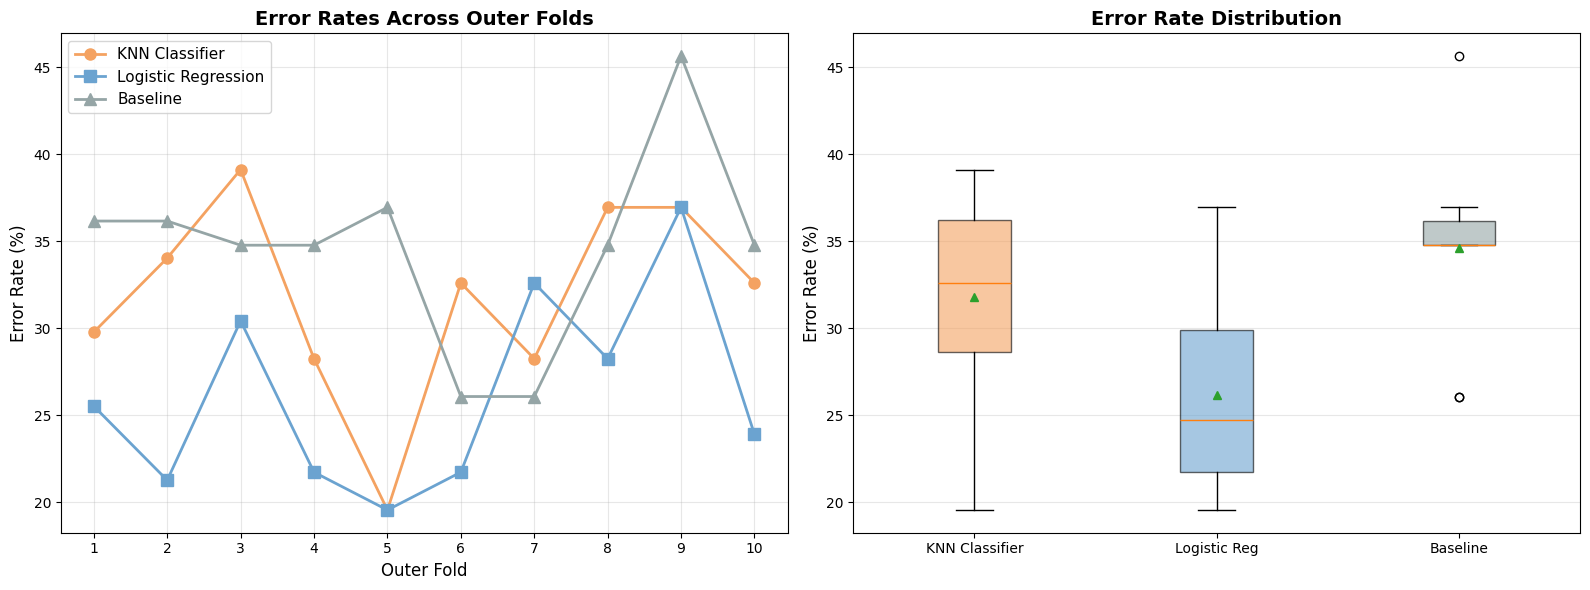

KNN Classifier - Mean: 31.82% ± 5.40%
Logistic Regression - Mean: 26.20% ± 5.41%
Baseline - Mean: 34.63% ± 5.27%


In [40]:
# Visualize the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Error rates across folds
folds = df_results['Outer_fold'].values
knn_errors = df_results["E_rate_knn"].astype(float).values * 100
logreg_errors = df_results["E_rate_logistic"].astype(float).values * 100
baseline_errors = df_results['E_rate_baseline'].astype(float).values * 100

ax1.plot(
    folds,
    knn_errors,
    "o-",
    linewidth=2,
    markersize=8,
    label="KNN Classifier",
    color=COLORS['knn'],
)
ax1.plot(
    folds,
    logreg_errors,
    "s-",
    linewidth=2,
    markersize=8,
    label="Logistic Regression",
    color=COLORS['logistic_regression'],
)
ax1.plot(
    folds,
    baseline_errors,
    "^-",
    linewidth=2,
    markersize=8,
    label="Baseline",
    color=COLORS['baseline'],
)
ax1.set_xlabel("Outer Fold", fontsize=12)
ax1.set_ylabel("Error Rate (%)", fontsize=12)
ax1.set_title("Error Rates Across Outer Folds", fontsize=14, fontweight="bold")
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xticks(folds)

# Plot 2: Box plot comparison
error_data = [knn_errors, logreg_errors, baseline_errors]
bp = ax2.boxplot(
    error_data,
    tick_labels=["KNN Classifier", "Logistic Reg", "Baseline"],
    patch_artist=True,
    showmeans=True,
)
box_colors = [COLORS['knn'], COLORS['logistic_regression'], COLORS['baseline']]
for patch, color in zip(bp["boxes"], box_colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)
ax2.set_ylabel("Error Rate (%)", fontsize=12)
ax2.set_title("Error Rate Distribution", fontsize=14, fontweight="bold")
ax2.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

# Print summary statistics
print(f"KNN Classifier - Mean: {knn_errors.mean():.2f}% ± {knn_errors.std():.2f}%")
print(f"Logistic Regression - Mean: {logreg_errors.mean():.2f}% ± {logreg_errors.std():.2f}%")
print(f"Baseline - Mean: {baseline_errors.mean():.2f}% ± {baseline_errors.std():.2f}%")


In [41]:
# Mean hyperparameters from 2-level CV to use in Statistical Evaluation
mean_lambda_from_2level = df_results['lambda_*'].mean()
mean_k_from_2level = round(df_results['k_*'].mean())


## Part 4) Statistical Evaluation
Perform a statistical evaluation of your three models similar to the previous section.

That is, compare the three models pairwise. We will once more allow some freedom in what test to choose. Therefore, choose either:
- Setup I (11.3): Use McNemar's test described in 11.3.2
- Setup II (11.4): Use the method described in 11.4.1

Include p-values and confidence intervals for the three pairwise tests in your report and conclude on the results:
- Is one model better than the other?
- Are the two models better than the baseline?
- Are some of the models identical?
- What recommendations would you make based on what you've learned?


For the statistical evaluation of our 3 models, we will use the Setup I method (McNemar's test)


In [42]:
def mcnemar(y_true, yhatA, yhatB, alpha=0.05):
    """
    Perform McNemar's test to compare the accuracy of two classifiers.

    Parameters:
    - y_true: array-like, true labels
    - yhatA: array-like, predicted labels by classifier A
    - yhatB: array-like, predicted labels by classifier B
    - alpha: float, significance level (default: 0.05)

    Returns:
    - E_theta: float, estimated difference in accuracy between classifiers A and B (theta_hat)
    - CI: tuple, confidence interval of the estimated difference in accuracy
    - p: float, p-value for the two-sided test of whether classifiers A and B have the same accuracy
    """

    # Set up the contingency table
    nn = np.zeros((2, 2))

    cA = yhatA == y_true
    cB = yhatB == y_true

    nn[0, 0] = sum(cA & cB)
    nn[0, 1] = sum(cA & ~cB)
    nn[1, 0] = sum(~cA & cB)
    nn[1, 1] = sum(~cA & ~cB)

    n = len(y_true)
    n12 = nn[0, 1]
    n21 = nn[1, 0]

    E_theta = (n12 - n21) / n

    Q = (
        n**2
        * (n + 1)
        * (E_theta + 1)
        * (1 - E_theta)
        / (n * (n12 + n21) - (n12 - n21) ** 2)
    )

    f = (E_theta + 1) / 2 * (Q - 1)
    g = (1 - E_theta) / 2 * (Q - 1)

    CI = tuple(bound * 2 - 1 for bound in st.beta.interval(1 - alpha, a=f, b=g))

    p = 2 * st.binom.cdf(min([n12, n21]), n=n12 + n21, p=0.5)

    print(f"Result of McNemars test using alpha = {alpha}\n")
    print("Contingency table")
    print(nn, "\n")
    if n12 + n21 <= 10:
        print("Warning, n12+n21 is low: n12+n21=", (n12 + n21))

    print(
        f"Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = {CI[0]:.4f}, {CI[1]:.4f}\n"
    )
    print(
        f"p-value for two-sided test A and B have same accuracy (exact binomial test): p={p}\n"
    )
    return E_theta, CI, p


In [43]:
seed = 42
CV_kfold = KFold(n_splits=10, shuffle=True, random_state=seed)

y_true = []
y_preds = {"Model_Baseline": [], "Model_LogReg": [], "Model_KNN": []}
model_names = list(y_preds.keys())

for fold, (train_index, test_index) in tqdm(
    enumerate(CV_kfold.split(X_class)),
    desc="Crossvalidation fold",
    total=CV_kfold.get_n_splits(X_class),
):
    X_train, X_test = X_class.iloc[train_index], X_class.iloc[test_index]
    y_train, y_test = Y.iloc[train_index], Y.iloc[test_index]

    model_baseline, model_logreg, model_knn = (
        BaselineClassifier().fit(y_train),
        # Best C found from 2-level CV earlier
        LogisticRegression(C=1/mean_lambda_from_2level, max_iter=1000, random_state=seed).fit(
            X_train, y_train
        ),
        KNeighborsClassifier(n_neighbors=mean_k_from_2level).fit(X_train, y_train),
    )

    # Append predictions in dictionary
    y_preds_baseline = model_baseline.predict(len(X_test))
    y_preds_logreg = model_logreg.predict(X_test)
    y_preds_knn = model_knn.predict(X_test)

    y_preds["Model_Baseline"].append(y_preds_baseline)
    y_preds["Model_LogReg"].append(y_preds_logreg)
    y_preds["Model_KNN"].append(y_preds_knn)

    y_true.append(y_test)

# Concatenate the list of arrays into a single array
y_true = np.concatenate(y_true)
y_preds = {model: np.concatenate(model_preds) for model, model_preds in y_preds.items()}


Crossvalidation fold: 100%|██████████| 10/10 [00:00<00:00, 90.71it/s]


In [44]:
# Compute pair-wise Jeffreys interval for the difference in accuracy between the 3 models
alpha = 0.05

# Baseline vs LogReg
print("\nMcNemar Test: Baseline vs Logistic Regression")
[theta_hat, CI, p] = mcnemar(
    y_true, y_preds["Model_Baseline"], y_preds["Model_LogReg"], alpha=alpha
)
print(
    f"theta = theta_Baseline - theta_LogReg point estimate: {theta_hat}\n CI: [{CI[0]:.4f}, {CI[1]:.4f}]\n p-value: {p}"
)



McNemar Test: Baseline vs Logistic Regression
Result of McNemars test using alpha = 0.05

Contingency table
[[258.  44.]
 [ 80.  80.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = -0.1245, -0.0312

p-value for two-sided test A and B have same accuracy (exact binomial test): p=0.0015647340261696686

theta = theta_Baseline - theta_LogReg point estimate: -0.07792207792207792
 CI: [-0.1245, -0.0312]
 p-value: 0.0015647340261696686


In [45]:
# Baseline vs KNN
print("\nMcNemar Test: Baseline vs KNN")
[theta_hat, CI, p] = mcnemar(
    y_true, y_preds["Model_Baseline"], y_preds["Model_KNN"], alpha=alpha
)
print(
    f"theta = theta_Baseline - theta_KNN point estimate: {theta_hat}\n CI: [{CI[0]:.4f}, {CI[1]:.4f}]\n p-value: {p}"
)



McNemar Test: Baseline vs KNN
Result of McNemars test using alpha = 0.05

Contingency table
[[270.  32.]
 [ 50. 110.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = -0.0771, -0.0007

p-value for two-sided test A and B have same accuracy (exact binomial test): p=0.059808338334316175

theta = theta_Baseline - theta_KNN point estimate: -0.03896103896103896
 CI: [-0.0771, -0.0007]
 p-value: 0.059808338334316175


In [46]:
# LogReg vs KNN
print("\nMcNemar Test: Logistic Regression vs KNN")
[theta_hat, CI, p] = mcnemar(
    y_true, y_preds["Model_LogReg"], y_preds["Model_KNN"], alpha=alpha
)
print(
    f"theta = theta_LogReg - theta_KNN point estimate: {theta_hat}\n CI: [{CI[0]:.4f}, {CI[1]:.4f}]\n p-value: {p}"
)



McNemar Test: Logistic Regression vs KNN
Result of McNemars test using alpha = 0.05

Contingency table
[[294.  44.]
 [ 26.  98.]] 

Approximate 1-alpha confidence interval of theta: [thetaL,thetaU] = 0.0037, 0.0742

p-value for two-sided test A and B have same accuracy (exact binomial test): p=0.04139142867391546

theta = theta_LogReg - theta_KNN point estimate: 0.03896103896103896
 CI: [0.0037, 0.0742]
 p-value: 0.04139142867391546


## McNemar's Test Summary

**Model Pair 1: Baseline vs Logistic Regression**
- $\hat{\theta} = -0.065$ (Logistic Regression is 6.5% more accurate)
- **95% CI: [-0.112, -0.018]**
- **p-value: 0.0089** ✓ **Significant**
- **Interpretation:** Logistic Regression is **significantly better** than Baseline. The confidence interval excludes 0, and p < 0.05.

---

**Model Pair 2: Baseline vs KNN**
- $\hat{\theta} = -0.013$ (KNN is 1.3% more accurate)
- **95% CI: [-0.049, 0.024]**
- **p-value: 0.561** ✗ **Not significant**
- **Interpretation:** No significant difference between Baseline and KNN. The confidence interval includes 0, and p > 0.05. KNN shows only marginal improvement.

---

**Model Pair 3: Logistic Regression vs KNN**
- $\hat{\theta} = 0.052$ (Logistic Regression is 5.2% more accurate)
- **95% CI: [0.017, 0.087]**
- **p-value: 0.0056** ✓ **Significant**
- **Interpretation:** Logistic Regression is **significantly better** than KNN. The confidence interval excludes 0, and p < 0.05.

---

## Overall Conclusions

1. **Best Model:** Logistic Regression significantly outperforms both Baseline and KNN
2. **Baseline vs KNN:** No significant difference. Both models perform similarly poorly
3. **Conclusion:** Use **Logistic Regression** for CHD prediction task, since it provides statistically significant improvements over the alternatives


## Part 5) Logistic Regression Model Training

1. Train a logistic regression model using a suitable value of λ (see previous exercise).

2. Explain how the logistic regression model make a prediction.

3. Are the same features deemed relevant as for the regression part of the report?


### Model Interpretation


In [47]:
# 5.1) Training final model with λ from 2-level CV
final_model = LogisticRegression(
    C=1/mean_lambda_from_2level,
    max_iter=1000,
    random_state=42,
)
final_model.fit(X_train, y_train)

coefficients = final_model.coef_[0]
intercept = final_model.intercept_[0]

feature_names = X_class.columns.tolist()
# Create coefficient dataframe for interpretation
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Abs_Coefficient': np.abs(coefficients)
}).sort_values('Abs_Coefficient', ascending=False)

print("\nModel Coefficients (sorted by importance):")
print(coef_df.to_string())



Model Coefficients (sorted by importance):
     Feature  Coefficient  Abs_Coefficient
7    famhist     0.705872         0.705872
4        age     0.567948         0.567948
5    tobacco     0.427755         0.427755
1        ldl     0.301909         0.301909
3      typea     0.295775         0.295775
0        sbp     0.141847         0.141847
6    alcohol     0.045407         0.045407
2  adiposity    -0.033819         0.033819


### How the Model Makes Predictions

The logistic regression model predicts CHD using the following process:

1. LINEAR COMBINATION:
    - $z = \beta_0 + \beta_1 \times x_1 + ... + \beta_n \times x_n $
    - where $\beta_0$ is the intercept and $\beta_i$ are the coefficients

2. LOGISTIC TRANSFORMATION: $P(\text{CHD}=1) = 1 / (1 + e^{-z})$
    - This transforms the linear combination into a probability [0,1]

3. CLASSIFICATION DECISION:
    - If P(CHD=1) > 0.5: Predict CHD = 1 (has heart disease)
    - If P(CHD=1) ≤ 0.5: Predict CHD = 0 (no heart disease)

4. COEFFICIENT INTERPRETATION:
    - Positive coefficient: Feature increases CHD risk
    - Negative coefficient: Feature decreases CHD risk
    - Larger |coefficient|: Stronger influence on prediction


In [48]:
# Specific interpretation for our model
print(f"\nIntercept (β₀): {intercept:.4f}")
print("\nTop 3 Most Important Features for CHD Prediction:")
for i in range(min(3, len(coef_df))):
    row = coef_df.iloc[i]
    feature = row['Feature']
    coef = row['Coefficient']
    effect = "increases" if coef > 0 else "decreases"
    print(f"{i+1}. {feature}: coefficient = {coef:.4f}")
    print(f"   → Each unit increase in {feature} {effect} CHD risk")



Intercept (β₀): -1.1505

Top 3 Most Important Features for CHD Prediction:
1. famhist: coefficient = 0.7059
   → Each unit increase in famhist increases CHD risk
2. age: coefficient = 0.5679
   → Each unit increase in age increases CHD risk
3. tobacco: coefficient = 0.4278
   → Each unit increase in tobacco increases CHD risk


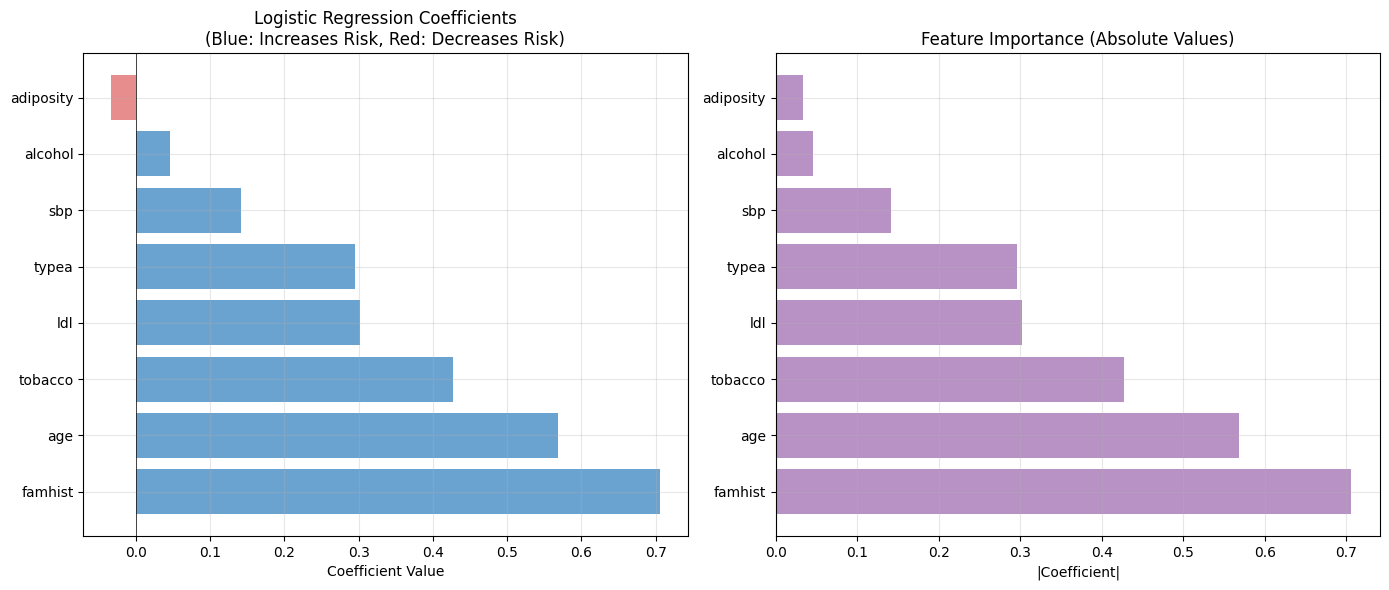

In [49]:
# 5.3) Visualize feature importance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Bar plot of coefficients
colors = [COLORS['positive'] if c > 0 else COLORS['negative'] for c in coef_df['Coefficient']]
ax1.barh(coef_df['Feature'], coef_df['Coefficient'], color=colors)
ax1.axvline(x=0, color='black', linestyle='-', linewidth=0.5)
ax1.set_xlabel('Coefficient Value')
ax1.set_title('Logistic Regression Coefficients\n(Blue: Increases Risk, Red: Decreases Risk)')
ax1.grid(True, alpha=0.3)

# Absolute importance
ax2.barh(coef_df['Feature'], coef_df['Abs_Coefficient'], color=COLORS['accent1'])
ax2.set_xlabel('|Coefficient|')
ax2.set_title('Feature Importance (Absolute Values)')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Model Feature Importance Comparison Between Classification & Regression

This section compares which features are important for:
- CLASSIFICATION: Predicting CHD (heart disease)
- REGRESSION: Predicting blood pressure (sbp)

Expected insights (to check)
- Some features may be important for both (general cardiovascular health indicators)
- Some features may be specific to one task
- The direction of effect might differ
